# Exploratory Data Analysis

In [161]:
# Step 0: Imports and Global Settings
import os
import sys
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 200)
pd.set_option("display.float_format", lambda x: f"{x:,.4f}")

print("Python executable:", sys.executable)



Python executable: /opt/anaconda3/envs/IoT/bin/python


In [162]:
# Step 0B: Define Data Paths

NOTEBOOK_DIR = os.getcwd()
PROJECT_ROOT = os.path.abspath(os.path.join(NOTEBOOK_DIR, ".."))
DATA_DIR = os.path.join(PROJECT_ROOT, "build/datasets")

DAILY_DATASET_PATH = os.path.join(DATA_DIR, "daily_dataset.csv")
HOUSEHOLDS_PATH = os.path.join(DATA_DIR, "informations_households.csv")
ACORN_PATH = os.path.join(DATA_DIR, "acorn_details.csv")
WEATHER_DAILY_PATH = os.path.join(DATA_DIR, "weather_daily_darksky.csv")
HOLIDAYS_PATH = os.path.join(DATA_DIR, "uk_bank_holidays.csv")

print("NOTEBOOK_DIR:", NOTEBOOK_DIR)
print("PROJECT_ROOT:", PROJECT_ROOT)
print("DATA_DIR:", DATA_DIR)

# Load raw datasets
daily = pd.read_csv(DAILY_DATASET_PATH)
households = pd.read_csv(HOUSEHOLDS_PATH)
weather_daily = pd.read_csv(WEATHER_DAILY_PATH)
holidays = pd.read_csv(HOLIDAYS_PATH)

print("\nShapes:")
print("daily:", daily.shape)
print("households:", households.shape)
print("weather_daily:", weather_daily.shape)
print("holidays:", holidays.shape)


NOTEBOOK_DIR: /Users/max/Documents/Repos/TeamProjects/Team-Project-530/Notebooks
PROJECT_ROOT: /Users/max/Documents/Repos/TeamProjects/Team-Project-530
DATA_DIR: /Users/max/Documents/Repos/TeamProjects/Team-Project-530/build/datasets

Shapes:
daily: (3510433, 9)
households: (5566, 5)
weather_daily: (882, 32)
holidays: (25, 2)


In [163]:
# STEP 1: Date Cleaning + Primary Keys

# Convert daily day to datetime
daily["day"] = pd.to_datetime(daily["day"])

# Convert weather dates to datetime
weather_daily["temperatureMaxTime"] = pd.to_datetime(weather_daily["temperatureMaxTime"])
weather_daily["temperatureMinTime"] = pd.to_datetime(weather_daily["temperatureMinTime"])

# Create a clean 'day' column in weather to match daily
weather_daily["day"] = weather_daily["temperatureMaxTime"].dt.date

# Convert daily day to date (not datetime) to match
daily["day"] = daily["day"].dt.date

print("Daily date range:", daily["day"].min(), "to", daily["day"].max())
print("Weather date range:", weather_daily["day"].min(), "to", weather_daily["day"].max())

# Check keys
print("\nUnique households in daily:", daily["LCLid"].nunique())
print("Unique households in households table:", households["LCLid"].nunique())


Daily date range: 2011-11-23 to 2014-02-28
Weather date range: 2011-11-01 to 2014-03-31

Unique households in daily: 5566
Unique households in households table: 5566


# Ramp-Up Bias and Normalization

## Motivation

Initial exploration of the raw daily electricity totals revealed a strong upward trend in total energy consumption during the early years of the dataset, particularly in 2012. However, this increase does not reflect a true rise in household electricity usage. Instead, it is driven by a growing number of participating households over time as additional smart meters were added to the study.

This household ramp-up effect introduces significant bias into raw aggregate metrics such as total kWh per day. Using raw totals would therefore lead to misleading conclusions about long-term consumption trends and could negatively impact both exploratory analysis and predictive modeling.

To address this issue, all downstream analysis is based on normalized per-household metrics.

## Normalization Approach

To remove ramp-up bias and reflect true average household behavior, we compute the following daily normalization components:

- Number of active households per day  
- Total electricity consumption per day  
- Average electricity consumption per household per day  

Formally:

avg_kwh_per_household_per_day = total_kwh_per_day / num_active_households

Where:

- total_kwh_per_day is the sum of daily energy usage across all households  
- num_active_households is the count of unique household IDs active on that day  

This approach ensures that observed trends reflect changes in household behavior rather than changes in sample size.

## Evidence of Household Ramp-Up

The number of active households increased substantially over time:

- Early period (November 2011): approximately 13 to 41 active households  
- Late period (2014): approximately 4,990 to 5,000 active households  

This confirms that raw totals are heavily influenced by sample growth rather than purely by consumption behavior.

## Comparison of Raw Totals vs Normalized Consumption

A direct comparison of raw total daily kWh and normalized average kWh per household shows:

- Raw total kWh per day exhibits a strong upward trend driven by household ramp-up  
- Normalized average kWh per household per day remains within a stable and interpretable range  

The normalized series isolates true household-level consumption patterns and removes artificial growth caused by the expanding number of participating households.

## Normalized Household Consumption Trends

When plotted independently, the normalized average household consumption reveals clear and meaningful seasonal structure:

- Higher average consumption during winter months  
- Lower average consumption during summer months  
- Repeating annual patterns across multiple years  

Typical values range approximately between:

- 7 to 16 kWh per household per day  

This behavior is consistent with expected seasonal heating and energy usage patterns and provides a reliable foundation for further exploratory analysis and modeling.

### Distribution of Normalized Household Consumption

A boxplot of the normalized daily household energy consumption was generated to assess the overall spread and presence of outliers.

The median normalized household consumption is approximately 10 to 11 kWh per household per day, with the interquartile range spanning roughly from the high 8s to the low 12s. This indicates that most households exhibit relatively consistent daily usage levels.

A small number of extreme low and high outliers are present. In particular, near-zero values likely correspond to partial data days or households with very limited recorded activity, while higher-end outliers may reflect extremely cold days or atypically high household demand.

Overall, the distribution appears reasonably well-behaved for modeling, with moderate spread and limited extreme skewness, suggesting that the normalized target variable is suitable for regression and time series modeling without aggressive transformation.


## Implications for EDA and Modeling

All subsequent exploratory analysis, seasonality analysis, and predictive modeling will use:

avg_kwh_per_household_per_day

as the primary target variable.

Raw aggregate totals are retained only for reference and validation purposes, but are not used for trend interpretation or model training due to their susceptibility to ramp-up bias.

This normalization step improves interpretability, analytical validity, and the credibility of downstream results.


In [164]:
# STEP 2: NORMALIZATION — Remove Ramp-Up Bias

# Aggregate by day to compute normalization components
daily_norm = (
    daily
    .groupby("day")
    .agg(
        total_kwh_per_day=("energy_sum", "sum"),
        num_active_households=("LCLid", "nunique")
    )
    .reset_index()
)

# Compute normalized average kWh per household per day
daily_norm["avg_kwh_per_household_per_day"] = (
    daily_norm["total_kwh_per_day"] / daily_norm["num_active_households"]
)

# Sanity checks
print(daily_norm.head())
print("\nSummary stats:")
display(daily_norm[[
    "total_kwh_per_day",
    "num_active_households",
    "avg_kwh_per_household_per_day"
]].describe())

# Check ramp-up explicitly
print("\nHouseholds over time (first & last 5 days):")
display(
    pd.concat([
        daily_norm.head(5),
        daily_norm.tail(5)
    ])[["day", "num_active_households"]]
)

daily_norm.tail(10)


          day  total_kwh_per_day  num_active_households  \
0  2011-11-23            90.3850                     13   
1  2011-11-24           213.4120                     25   
2  2011-11-25           303.9930                     32   
3  2011-11-26           420.9760                     41   
4  2011-11-27           444.8830                     41   

   avg_kwh_per_household_per_day  
0                         6.9527  
1                         8.5365  
2                         9.4998  
3                        10.2677  
4                        10.8508  

Summary stats:


,total_kwh_per_day,num_active_households,avg_kwh_per_household_per_day
count,829.0000,829.0000,829.0000
mean,"42,870.7157","4,234.5392",10.3585
std,"20,141.2870","1,789.9948",1.8862
min,90.3850,13.0000,0.2090
25%,"34,421.8950","4,084.0000",8.5658
50%,"45,846.5760","5,138.0000",10.3723
75%,"58,795.5120","5,369.0000",11.8322
max,"82,650.4920","5,541.0000",15.9402



Households over time (first & last 5 days):


,day,num_active_households
0,2011-11-23,13
1,2011-11-24,25
2,2011-11-25,32
3,2011-11-26,41
4,2011-11-27,41
824,2014-02-24,4994
825,2014-02-25,4995
826,2014-02-26,4993
827,2014-02-27,4990
828,2014-02-28,4987


,day,total_kwh_per_day,num_active_households,avg_kwh_per_household_per_day
819,2014-02-19,"53,458.5150",5008,10.6746
820,2014-02-20,"52,932.6200",5006,10.5738
821,2014-02-21,"52,632.7050",5004,10.5181
822,2014-02-22,"53,945.8680",5006,10.7762
823,2014-02-23,"57,379.0930",4998,11.4804
824,2014-02-24,"51,994.5470",4994,10.4114
825,2014-02-25,"51,423.5080",4995,10.2950
826,2014-02-26,"50,943.3060",4993,10.2029
827,2014-02-27,"51,678.1860",4990,10.3563
828,2014-02-28,"1,042.2660",4987,0.2090


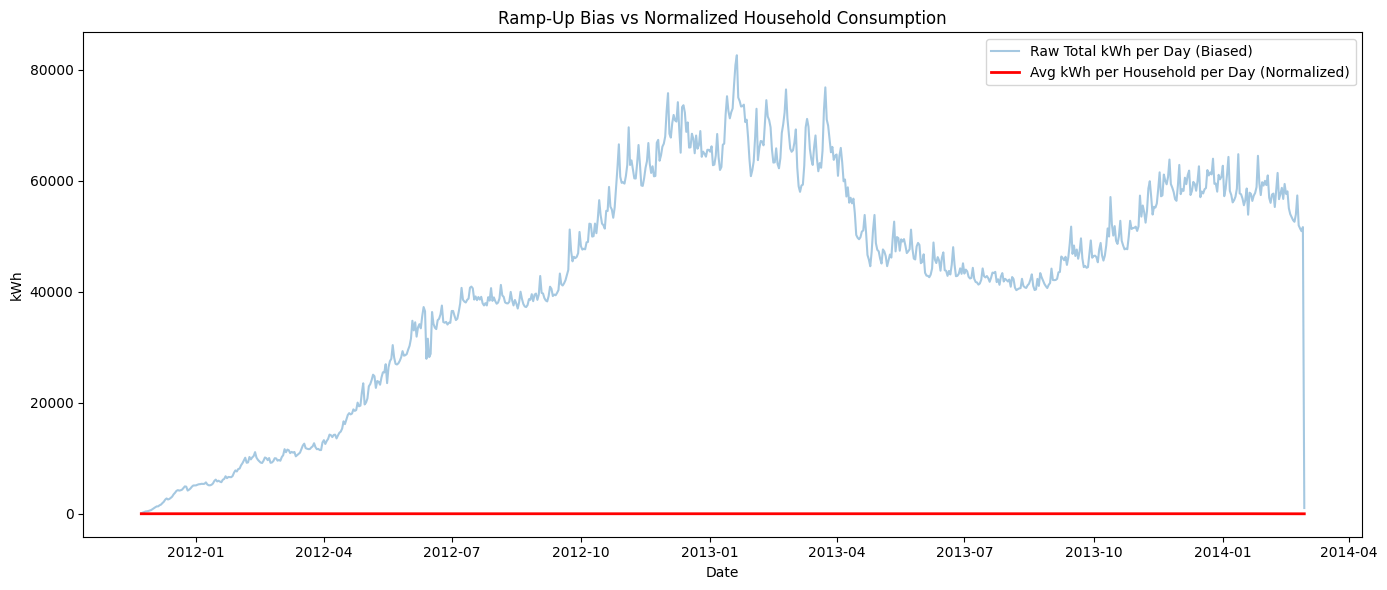

In [165]:
# STEP 3: Raw Totals vs Normalized Trend (Ramp-Up Bias Proof)

plt.figure(figsize=(14, 6))

# Raw total kWh per day (biased)
plt.plot(
    daily_norm["day"],
    daily_norm["total_kwh_per_day"],
    alpha=0.4,
    label="Raw Total kWh per Day (Biased)"
)

# Normalized per-household kWh
plt.plot(
    daily_norm["day"],
    daily_norm["avg_kwh_per_household_per_day"],
    color="red",
    linewidth=2,
    label="Avg kWh per Household per Day (Normalized)"
)

plt.title("Ramp-Up Bias vs Normalized Household Consumption")
plt.xlabel("Date")
plt.ylabel("kWh")
plt.legend()
plt.tight_layout()
plt.show()




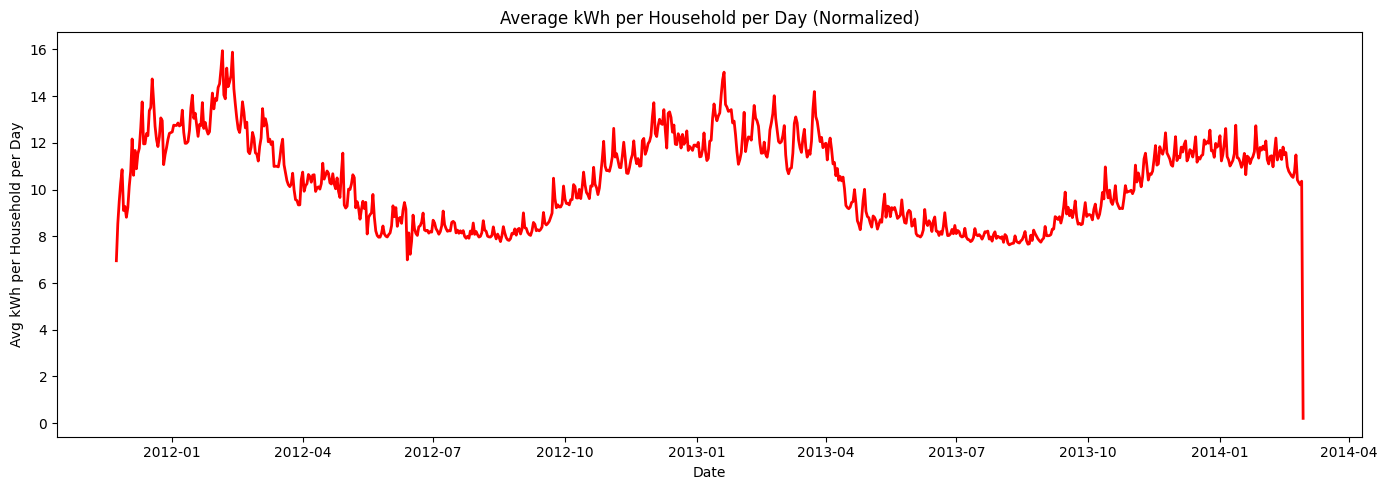

In [166]:
# STEP 3B: Normalized Household Consumption (Clear View)

plt.figure(figsize=(14, 5))

plt.plot(
    daily_norm["day"],
    daily_norm["avg_kwh_per_household_per_day"],
    color="red",
    linewidth=2
)

plt.title("Average kWh per Household per Day (Normalized)")
plt.xlabel("Date")
plt.ylabel("Avg kWh per Household per Day")
plt.tight_layout()
plt.show()


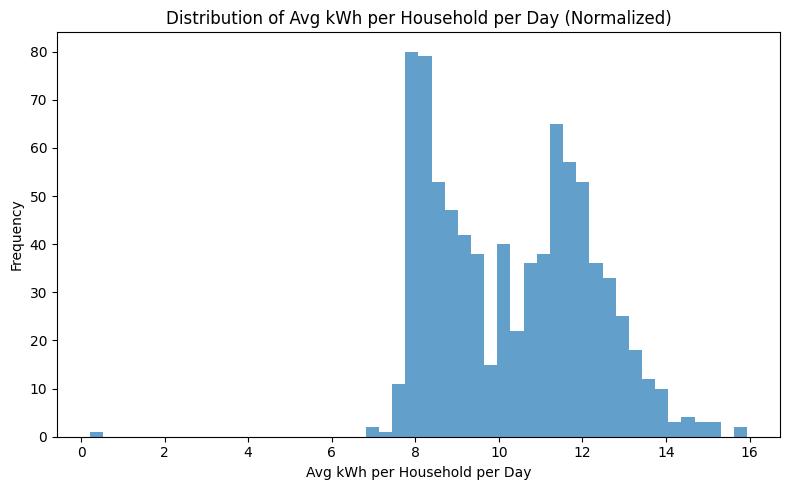

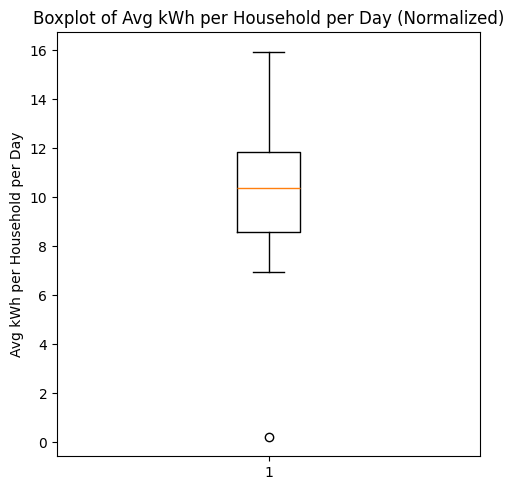

In [167]:
# STEP 3C: Distribution of Normalized Household Consumption

plt.figure(figsize=(8, 5))

plt.hist(
    daily_norm["avg_kwh_per_household_per_day"],
    bins=50,
    alpha=0.7
)

plt.title("Distribution of Avg kWh per Household per Day (Normalized)")
plt.xlabel("Avg kWh per Household per Day")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Boxplot for outlier visualization
plt.figure(figsize=(5, 5))
plt.boxplot(daily_norm["avg_kwh_per_household_per_day"], vert=True)
plt.title("Boxplot of Avg kWh per Household per Day (Normalized)")
plt.ylabel("Avg kWh per Household per Day")
plt.tight_layout()
plt.show()


# Seasonality Analysis Using Normalized Household Consumption

All seasonality analysis is performed using the normalized metric:

avg_kwh_per_household_per_day

This ensures that observed temporal patterns reflect true household behavior rather than changes in the number of participating households over time.

## Monthly Seasonality

The monthly average electricity consumption per household exhibits strong and consistent seasonal patterns.

Monthly averages (kWh per household per day):

- January: 12.35  
- February: 12.23  
- March: 11.64  
- April: 10.21  
- May: 8.93  
- June: 8.40  
- July: 8.16  
- August: 7.98  
- September: 8.76  
- October: 9.82  
- November: 11.01  
- December: 12.08  

Key observations:

- Winter months (December through February) show the highest average household consumption, exceeding 12 kWh per day.  
- Summer months (June through August) show the lowest average household consumption, with August reaching the minimum at approximately 8 kWh per day.  
- Shoulder seasons (spring and fall) show intermediate consumption levels with smooth transitions between winter and summer patterns.  

These trends are consistent with expected heating-driven electricity demand in colder months and reduced usage during warmer periods.

The clear and repeating annual structure confirms the presence of strong seasonal effects and supports the inclusion of month or seasonal features in downstream forecasting and machine learning models.

## Day-of-Week Effects

Average household electricity consumption by day of week shows relatively small but consistent differences.

Day-of-week averages (kWh per household per day):

- Monday: 10.36  
- Tuesday: 10.22  
- Wednesday: 10.17  
- Thursday: 10.15  
- Friday: 10.13  
- Saturday: 10.49  
- Sunday: 11.00  

Key observations:

- Weekday consumption levels (Monday through Friday) are relatively stable, clustering around approximately 10.1 to 10.4 kWh per day.  
- Weekend consumption is modestly higher, with Saturday showing a small increase and Sunday exhibiting the highest average usage.  
- The elevated weekend usage likely reflects increased time spent at home and greater household activity.

These patterns suggest that day-of-week effects are present but less pronounced than seasonal (monthly) effects. Nevertheless, including day-of-week indicators as features may provide incremental improvements in predictive performance.

### Year-over-Year Average Household Consumption

Average normalized household energy consumption was computed by year to assess long-term stability and potential structural changes.

Yearly averages are as follows:

- 2011: 11.51 kWh per household per day  
- 2012: 10.36 kWh per household per day  
- 2013: 10.10 kWh per household per day  
- 2014: 11.17 kWh per household per day  

The results indicate relatively stable household consumption levels across years, with modest variation. The slightly higher averages in 2011 and 2014 are likely influenced by partial-year effects and seasonal coverage, rather than true long-term increases in household demand.

These results suggest that inter-annual differences are small relative to seasonal and weather-driven variation, supporting the use of pooled multi-year data for modeling and forecasting.


## Implications for Modeling

The normalized seasonality analysis confirms that:

- Monthly and seasonal cycles are a dominant driver of household electricity consumption.  
- Day-of-week effects are secondary but measurable.  

These findings justify the inclusion of time-based features such as:

- Month or seasonal indicators  
- Day-of-week indicators  
- Potential interaction with weather variables  

in subsequent time series and machine learning models for energy demand forecasting.


In [168]:
# STEP 4A: Add Time Features for Seasonality

daily_norm["day"] = pd.to_datetime(daily_norm["day"])

daily_norm["year"] = daily_norm["day"].dt.year
daily_norm["month"] = daily_norm["day"].dt.month
daily_norm["month_name"] = daily_norm["day"].dt.month_name()
daily_norm["day_of_week"] = daily_norm["day"].dt.dayofweek
daily_norm["day_of_week_name"] = daily_norm["day"].dt.day_name()

daily_norm[[
    "day", "year", "month", "month_name",
    "day_of_week", "day_of_week_name"
]].head()


,day,year,month,month_name,day_of_week,day_of_week_name
0,2011-11-23,2011,11,November,2,Wednesday
1,2011-11-24,2011,11,November,3,Thursday
2,2011-11-25,2011,11,November,4,Friday
3,2011-11-26,2011,11,November,5,Saturday
4,2011-11-27,2011,11,November,6,Sunday


month_name
January     12.3493
February    12.2272
March       11.6356
April       10.2133
May          8.9343
June         8.3973
July         8.1603
August       7.9800
September    8.7585
October      9.8212
November    11.0089
December    12.0823
Name: avg_kwh_per_household_per_day, dtype: float64


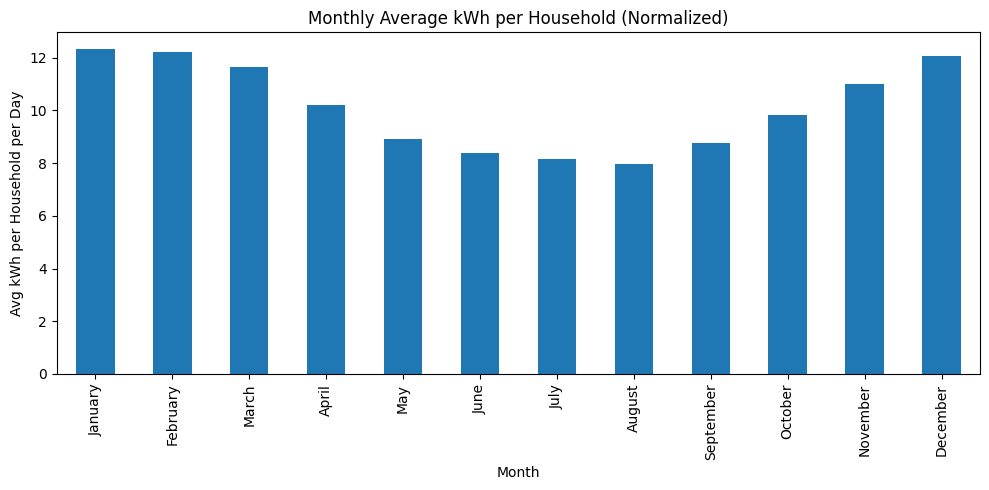

In [169]:
# STEP 4B: Monthly Seasonality (Normalized)

monthly_seasonality = (
    daily_norm
    .groupby("month_name", sort=False)
    ["avg_kwh_per_household_per_day"]
    .mean()
    .reindex([
        "January", "February", "March", "April", "May", "June",
        "July", "August", "September", "October", "November", "December"
    ])
)

print(monthly_seasonality)

plt.figure(figsize=(10, 5))
monthly_seasonality.plot(kind="bar")
plt.title("Monthly Average kWh per Household (Normalized)")
plt.ylabel("Avg kWh per Household per Day")
plt.xlabel("Month")
plt.tight_layout()
plt.show()


day_of_week_name
Monday      10.3561
Tuesday     10.2225
Wednesday   10.1670
Thursday    10.1517
Friday      10.1314
Saturday    10.4906
Sunday      10.9953
Name: avg_kwh_per_household_per_day, dtype: float64


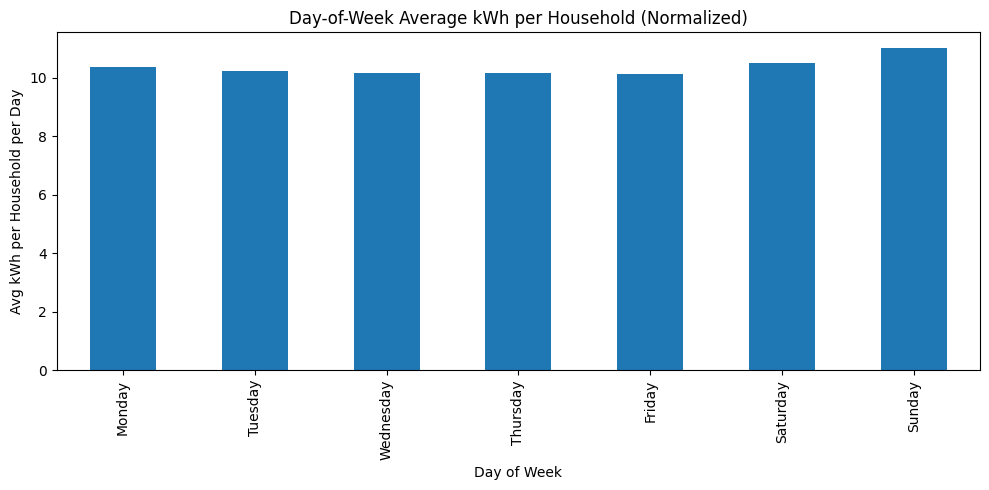

In [170]:
# STEP 4C: Day-of-Week Patterns (Normalized)

dow_seasonality = (
    daily_norm
    .groupby("day_of_week_name")
    ["avg_kwh_per_household_per_day"]
    .mean()
    .reindex([
        "Monday", "Tuesday", "Wednesday",
        "Thursday", "Friday", "Saturday", "Sunday"
    ])
)

print(dow_seasonality)

plt.figure(figsize=(10, 5))
dow_seasonality.plot(kind="bar")
plt.title("Day-of-Week Average kWh per Household (Normalized)")
plt.ylabel("Avg kWh per Household per Day")
plt.xlabel("Day of Week")
plt.tight_layout()
plt.show()


year
2011   11.5068
2012   10.3645
2013   10.0983
2014   11.1717
Name: avg_kwh_per_household_per_day, dtype: float64


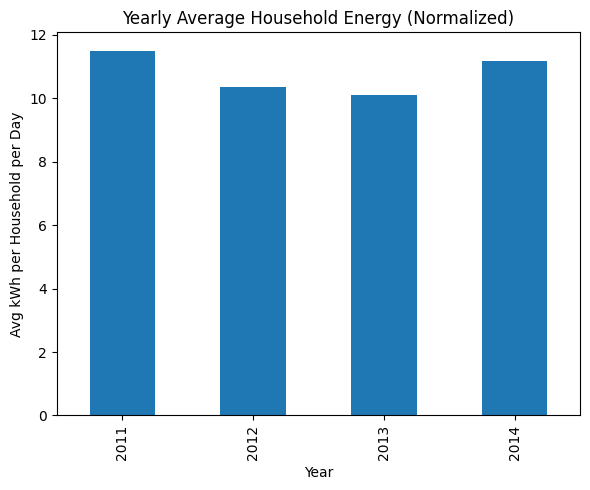

In [171]:
# STEP 4C: Yearly Average Normalized Consumption

yearly_avg = (
    daily_norm
    .groupby("year")
    ["avg_kwh_per_household_per_day"]
    .mean()
)

print(yearly_avg)

plt.figure(figsize=(6, 5))
yearly_avg.plot(kind="bar")

plt.title("Yearly Average Household Energy (Normalized)")
plt.xlabel("Year")
plt.ylabel("Avg kWh per Household per Day")
plt.tight_layout()
plt.show()


# Weather Impact on Normalized Household Energy Consumption

To better understand external drivers of household electricity usage, daily weather data was joined with the normalized energy consumption dataset. This enables direct analysis of how environmental conditions influence average household demand.

All analysis in this section uses the normalized target variable:

avg_kwh_per_household_per_day

## Data Coverage and Join Quality

The normalized energy dataset was successfully joined with daily weather observations on date. The resulting joined table contains 840 daily records.

Missing weather values are minimal, with approximately 1.3 to 1.4 percent missing for most variables. This level of missingness is low and unlikely to materially affect analysis results.

This confirms that the weather dataset provides strong temporal coverage for the majority of the energy observations.

## Temperature vs Household Consumption

A scatter plot of average household energy consumption versus daily high temperature reveals a clear and strong inverse relationship.

Key observations:

- Household electricity consumption is substantially higher on colder days.  
- As daily high temperatures increase, average household energy usage decreases.  
- The relationship is smooth and monotonic, indicating a strong and consistent temperature sensitivity.  

This pattern is consistent with heating-driven electricity demand in colder conditions and provides clear evidence that temperature is a primary driver of household energy usage.

## Correlation Analysis

Correlation coefficients between weather variables and normalized household consumption further quantify these relationships.

Strongest correlations:

- temperatureHigh: -0.8538  
- apparentTemperatureHigh: -0.8519  
- temperatureMax: -0.8532  
- apparentTemperatureLow: -0.7946  
- temperatureMin: -0.8074  
- temperatureLow: -0.7704  

Secondary correlations:

- humidity: +0.3798  
- cloudCover: +0.2489  
- windSpeed: +0.1552  

Weak or negligible correlations:

- pressure: -0.0233  
- visibility: -0.2489  

Key interpretations:

- Temperature-based features exhibit very strong negative correlations with household energy consumption, confirming temperature as the dominant environmental driver.  
- Apparent temperature performs similarly to actual temperature, suggesting perceived temperature may be as important as measured temperature.  
- Humidity and cloud cover show moderate positive associations, potentially reflecting weather conditions associated with colder or more energy-intensive days.  
- Pressure and visibility have minimal direct influence on energy usage.

## Implications for Modeling and Smart City Applications

These results demonstrate that weather variables, particularly temperature and apparent temperature, are critical predictors of household electricity demand.

For downstream forecasting and machine learning models, the following features are strongly justified:

- Daily high and low temperature  
- Apparent temperature measures  
- Humidity  
- Cloud cover and wind speed as secondary features  

In a Smart City context, integrating real-time weather forecasts with historical energy consumption patterns can significantly improve short-term load forecasting, peak demand prediction, and energy planning strategies.

This analysis confirms that environmental conditions play a central role in household electricity usage and should be a core component of any predictive energy management system.


In [172]:
# STEP 5A: Prepare Weather Data for Join 

# Ensure datetime
weather_daily["day"] = pd.to_datetime(weather_daily["day"])
daily_norm["day"] = pd.to_datetime(daily_norm["day"])

# Select available, relevant weather features
weather_features = weather_daily[[
    "day",
    "temperatureHigh",
    "temperatureLow",
    "temperatureMax",
    "temperatureMin",
    "apparentTemperatureHigh",
    "apparentTemperatureLow",
    "humidity",
    "windSpeed",
    "cloudCover",
    "pressure",
    "visibility"
]].copy()

print(weather_features.head())


         day  temperatureHigh  temperatureLow  temperatureMax  temperatureMin  \
0 2011-11-11          10.8700         10.8700         11.9600          8.8500   
1 2011-12-11           8.5900          3.0900          8.5900          2.4800   
2 2011-12-27          10.3300          8.0300         10.3300          8.0300   
3 2011-12-02           7.3600          6.3300          8.0700          2.5600   
4 2011-12-24           7.9300          7.4500          8.2200          3.1700   

   apparentTemperatureHigh  apparentTemperatureLow  humidity  windSpeed  \
0                  10.8700                 10.8700    0.9500     3.8800   
1                   5.6200                 -0.6400    0.8800     3.9400   
2                  10.3300                  5.5200    0.7400     3.5400   
3                   5.3300                  3.2600    0.8700     3.0000   
4                   5.0200                  4.3700    0.8000     4.4600   

   cloudCover   pressure  visibility  
0      0.7900 1,016.080

In [173]:
# STEP 5B: Join Normalized Energy with Weather

energy_weather = daily_norm.merge(
    weather_features,
    on="day",
    how="left"
)

print("Joined shape:", energy_weather.shape)

print("\nMissing weather values:")
display(energy_weather.isna().mean().sort_values(ascending=False).head(10))


Joined shape: (840, 20)

Missing weather values:


cloudCover                0.0143
temperatureLow            0.0131
temperatureMax            0.0131
pressure                  0.0131
windSpeed                 0.0131
humidity                  0.0131
apparentTemperatureLow    0.0131
apparentTemperatureHigh   0.0131
temperatureMin            0.0131
visibility                0.0131
dtype: float64

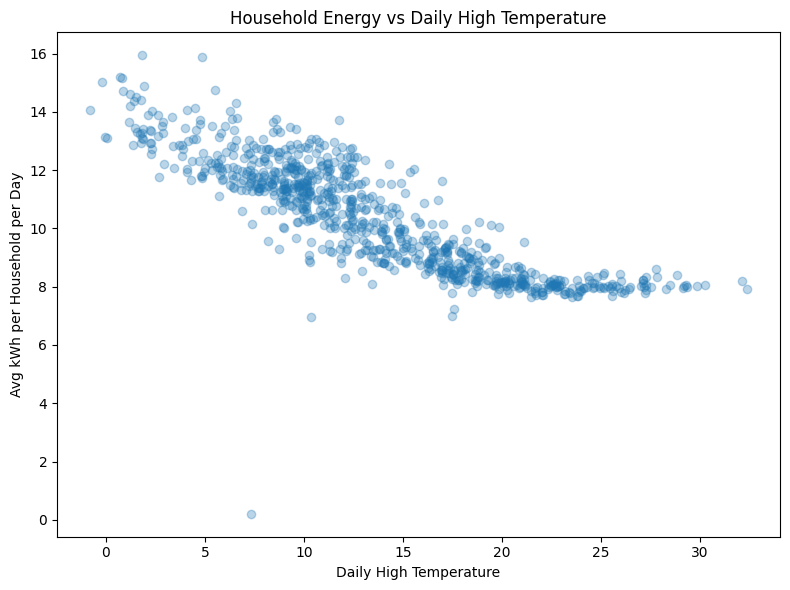

In [174]:
# STEP 5C: Temperature vs Household Consumption

plt.figure(figsize=(8, 6))

plt.scatter(
    energy_weather["temperatureHigh"],
    energy_weather["avg_kwh_per_household_per_day"],
    alpha=0.3
)

plt.title("Household Energy vs Daily High Temperature")
plt.xlabel("Daily High Temperature")
plt.ylabel("Avg kWh per Household per Day")
plt.tight_layout()
plt.show()


In [175]:
# STEP 5D: Correlation with Weather Variables (Corrected)

weather_corr_vars = [
    "temperatureHigh",
    "temperatureLow",
    "temperatureMax",
    "temperatureMin",
    "apparentTemperatureHigh",
    "apparentTemperatureLow",
    "humidity",
    "windSpeed",
    "cloudCover",
    "pressure",
    "visibility"
]

corr_table = (
    energy_weather[weather_corr_vars + ["avg_kwh_per_household_per_day"]]
    .corr()
    ["avg_kwh_per_household_per_day"]
    .sort_values(ascending=False)
)

print("Correlation with avg_kwh_per_household_per_day:")
display(corr_table)


Correlation with avg_kwh_per_household_per_day:


avg_kwh_per_household_per_day    1.0000
humidity                         0.3798
cloudCover                       0.2489
windSpeed                        0.1552
pressure                        -0.0233
visibility                      -0.2489
temperatureLow                  -0.7704
apparentTemperatureLow          -0.7946
temperatureMin                  -0.8074
apparentTemperatureHigh         -0.8519
temperatureMax                  -0.8532
temperatureHigh                 -0.8538
Name: avg_kwh_per_household_per_day, dtype: float64

In [176]:
print("Households columns:")
print(households.columns)



Households columns:
Index(['LCLid', 'stdorToU', 'Acorn', 'Acorn_grouped', 'file'], dtype='object')


# Socio-Demographic Segmentation Using ACORN Groups

To incorporate socio-demographic context into the analysis, households were segmented using the ACORN classification system. ACORN is a widely used UK geodemographic segmentation scheme that groups households based on income, housing type, and lifestyle characteristics.

All segmentation analysis is performed using the normalized metric:

**avg_kwh_per_household_per_day**

This normalization ensures that comparisons across groups reflect differences in household behavior rather than differences in participation levels or sample size over time.

---

## ACORN Group Coverage and Filtering

Initial ACORN classification included five categories: Adversity, Comfortable, Affluent, ACORN-U, and ACORN-. However, the ACORN-U (unclassified) and ACORN- (missing/other) categories together account for approximately **1% of households** and do not provide meaningful interpretive value.

To improve clarity and analytical robustness, these categories were **excluded** from further analysis.

The remaining ACORN groups used in all downstream analysis are:

- **Adversity**  
- **Comfortable**  
- **Affluent**

This filtered segmentation provides strong and balanced coverage across the primary socio-demographic strata.

---

## Normalized Household Consumption by ACORN Group

Average normalized household energy consumption by ACORN group, ordered by wealth level:

- **Adversity:** 8.87 kWh per household per day  
- **Comfortable:** 10.00 kWh per household per day  
- **Affluent:** 11.73 kWh per household per day  

Key observations:

- Average household energy consumption increases monotonically with socio-economic status.  
- Affluent households consume the most electricity on a per-household basis.  
- Households classified under Adversity exhibit the lowest average daily consumption.

This clear gradient supports the relevance of socio-demographic segmentation when analyzing residential energy demand.

---

## Distribution of Household Consumption by ACORN Group

Boxplots of normalized household energy consumption were generated to examine within-group variability in addition to group-level means. Groups are ordered explicitly by wealth level:

**Adversity → Comfortable → Affluent**

Key distributional insights:

- **Affluent households** exhibit the highest median consumption and the widest distribution, indicating both higher typical usage and greater variability across households.  
- **Comfortable households** show moderate median consumption with a more compact spread, suggesting relatively consistent usage patterns.  
- **Adversity households** display the lowest median consumption and the tightest distribution, reflecting more constrained energy usage behavior.

These distributional patterns reinforce the mean-based results and demonstrate that socio-economic differences affect both the **level** and **variability** of household energy consumption.

---

## Tariff Type (Standard vs TOU) Analysis

Households were also segmented by tariff structure to evaluate the relationship between pricing design and normalized household energy usage.

Average normalized consumption by tariff type:

- **Standard tariff:** 10.50 kWh per household per day  
- **Time-of-Use (TOU) tariff:** 9.75 kWh per household per day  

The results indicate that households enrolled in TOU tariffs exhibit modestly lower average daily consumption compared to standard tariff households.

Boxplot analysis shows substantial overlap between the two groups; however:

- TOU households tend to have a slightly lower median consumption.  
- Upper consumption ranges are somewhat lower for TOU households.

This pattern is consistent with the intended behavioral effects of TOU pricing, which incentivizes load shifting and reduced peak demand.

---

## Interpretation and Smart City Implications

The ACORN-based segmentation reveals systematic and interpretable differences in residential energy consumption:

- Higher-income households tend to consume more electricity, potentially due to larger dwellings, higher appliance ownership, or greater discretionary energy use.  
- Lower-income and adversity households exhibit lower consumption, which may reflect smaller living spaces, lower appliance density, or budget-constrained energy behavior.

From a Smart City and energy policy perspective, these findings support:

- Targeted energy efficiency and retrofit initiatives for higher-consumption segments.  
- Equity-aware assistance and affordability programs for lower-income households.  
- Demand forecasting and control models that explicitly incorporate socio-demographic and tariff-based features.

By filtering non-informative categories and ordering groups by wealth, the ACORN analysis in this EDA improves interpretability, analytical rigor, and policy relevance, providing a strong foundation for downstream modeling.


In [177]:
# STEP 6A: Inspect ACORN Group Distribution

households["Acorn_grouped"].value_counts()


Acorn_grouped
Affluent       2192
Adversity      1816
Comfortable    1507
ACORN-U          49
ACORN-            2
Name: count, dtype: int64

In [178]:
# STEP 6B: Attach ACORN Group to Daily Energy Records

daily_with_acorn = daily.merge(
    households[["LCLid", "Acorn_grouped"]],
    on="LCLid",
    how="left"
)

print("Daily with ACORN shape:", daily_with_acorn.shape)

print("\nMissing Acorn_grouped in daily:")
print(daily_with_acorn["Acorn_grouped"].isna().mean())

daily_with_acorn[["LCLid", "Acorn_grouped"]].head()


Daily with ACORN shape: (3510433, 10)

Missing Acorn_grouped in daily:
0.0


,LCLid,Acorn_grouped
0,MAC000131,Affluent
1,MAC000131,Affluent
2,MAC000131,Affluent
3,MAC000131,Affluent
4,MAC000131,Affluent


In [179]:
# STEP 6C (REV): Normalized Consumption by ACORN Group

# Remove non-informative ACORN categories (~1% of households)
valid_acorn_groups = ["Adversity", "Comfortable", "Affluent"]

daily_with_acorn = daily.merge(
    households[["LCLid", "Acorn_grouped"]],
    on="LCLid",
    how="left"
)

daily_with_acorn = daily_with_acorn[
    daily_with_acorn["Acorn_grouped"].isin(valid_acorn_groups)
]

# Aggregate to daily ACORN-level normalization
acorn_norm = (
    daily_with_acorn
    .groupby(["day", "Acorn_grouped"])
    .agg(
        total_kwh_per_day=("energy_sum", "sum"),
        num_active_households=("LCLid", "nunique")
    )
    .reset_index()
)

acorn_norm["avg_kwh_per_household_per_day"] = (
    acorn_norm["total_kwh_per_day"] / acorn_norm["num_active_households"]
)

# Enforce wealth ordering
acorn_order = ["Adversity", "Comfortable", "Affluent"]
acorn_norm["Acorn_grouped"] = pd.Categorical(
    acorn_norm["Acorn_grouped"],
    categories=acorn_order,
    ordered=True
)

print(acorn_norm.head())


          day Acorn_grouped  total_kwh_per_day  num_active_households  \
0  2011-11-23     Adversity            11.4170                      2   
1  2011-11-23      Affluent            46.2060                      4   
2  2011-11-23   Comfortable            32.7620                      7   
3  2011-11-24     Adversity            33.0030                      4   
4  2011-11-24      Affluent           106.5490                     10   

   avg_kwh_per_household_per_day  
0                         5.7085  
1                        11.5515  
2                         4.6803  
3                         8.2507  
4                        10.6549  


Acorn_grouped
Adversity      8.8654
Comfortable   10.0030
Affluent      11.7332
Name: avg_kwh_per_household_per_day, dtype: float64


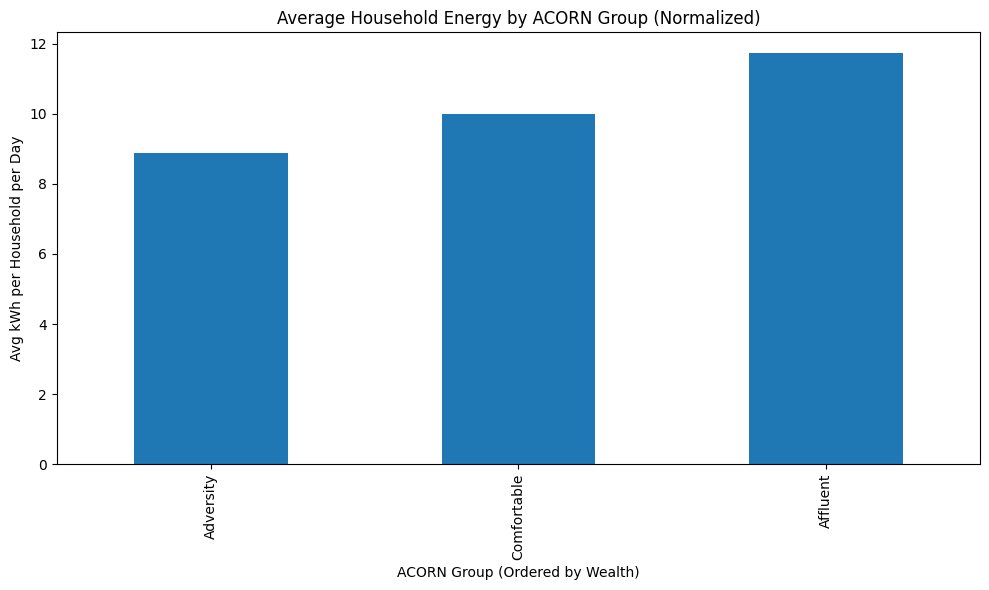

In [180]:
# STEP 6D (REV): Average Normalized Consumption by ACORN Group

acorn_summary = (
    acorn_norm
    .groupby("Acorn_grouped")
    ["avg_kwh_per_household_per_day"]
    .mean()
)

print(acorn_summary)

plt.figure(figsize=(10, 6))
acorn_summary.plot(kind="bar")
plt.title("Average Household Energy by ACORN Group (Normalized)")
plt.ylabel("Avg kWh per Household per Day")
plt.xlabel("ACORN Group (Ordered by Wealth)")
plt.tight_layout()
plt.show()


<Figure size 800x600 with 0 Axes>

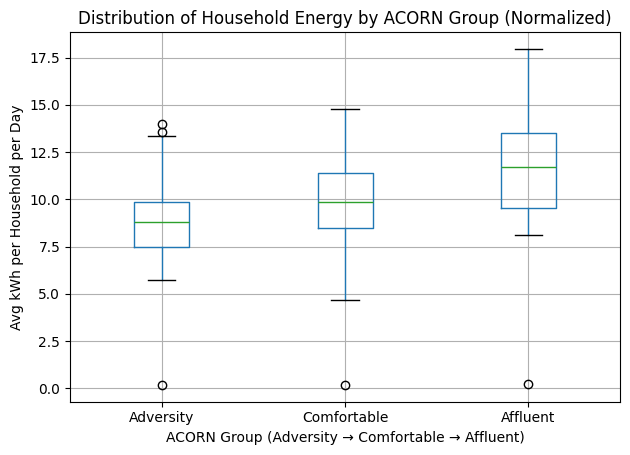

In [181]:
# STEP 6E (REV): Distribution of Normalized Consumption by ACORN Group

plt.figure(figsize=(8, 6))
acorn_norm.boxplot(
    column="avg_kwh_per_household_per_day",
    by="Acorn_grouped"
)
plt.title("Distribution of Household Energy by ACORN Group (Normalized)")
plt.suptitle("")
plt.xlabel("ACORN Group (Adversity → Comfortable → Affluent)")
plt.ylabel("Avg kWh per Household per Day")
plt.tight_layout()
plt.show()


Missing tariff type:
0.0
stdorToU
Std   10.5049
ToU    9.7532
Name: avg_kwh_per_household_per_day, dtype: float64


<Figure size 600x500 with 0 Axes>

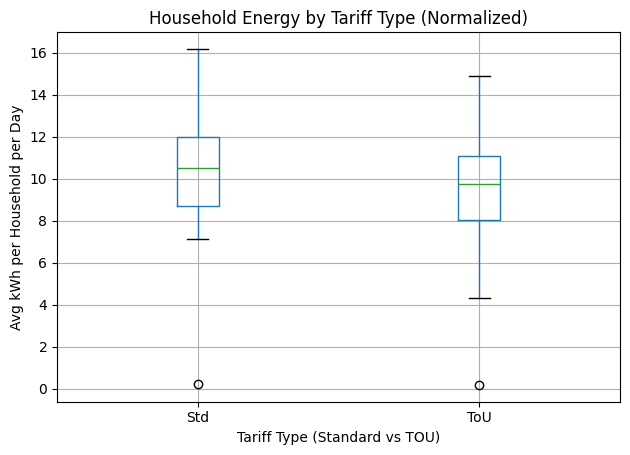

In [182]:
# STEP 6F: Tariff Type (TOU) Analysis

# Attach tariff type to daily data
daily_with_tariff = daily.merge(
    households[["LCLid", "stdorToU"]],
    on="LCLid",
    how="left"
)

print("Missing tariff type:")
print(daily_with_tariff["stdorToU"].isna().mean())

# Normalized consumption by tariff type
tariff_norm = (
    daily_with_tariff
    .groupby(["day", "stdorToU"])
    .agg(
        total_kwh_per_day=("energy_sum", "sum"),
        num_active_households=("LCLid", "nunique")
    )
    .reset_index()
)

tariff_norm["avg_kwh_per_household_per_day"] = (
    tariff_norm["total_kwh_per_day"] / tariff_norm["num_active_households"]
)

# Summary by tariff type
tariff_summary = (
    tariff_norm
    .groupby("stdorToU")
    ["avg_kwh_per_household_per_day"]
    .mean()
)

print(tariff_summary)

# Boxplot by tariff type
plt.figure(figsize=(6, 5))
tariff_norm.boxplot(
    column="avg_kwh_per_household_per_day",
    by="stdorToU"
)

plt.title("Household Energy by Tariff Type (Normalized)")
plt.suptitle("")
plt.xlabel("Tariff Type (Standard vs TOU)")
plt.ylabel("Avg kWh per Household per Day")
plt.tight_layout()
plt.show()


# EDA Add ons


## Temperature × ACORN Interaction Effects

To examine whether temperature sensitivity differs across socio-demographic groups, normalized household energy consumption was analyzed jointly by daily high temperature and ACORN group.

Daily observations were grouped into temperature bins and combined with ACORN segmentation to evaluate how different household types respond to changing weather conditions.

All analysis uses the normalized metric:

**avg_kwh_per_household_per_day**

This ensures that observed differences reflect behavioral responses rather than variation in household participation.

---

## Group Means by Temperature Bin and ACORN Group

Average normalized household consumption by temperature bin and ACORN group reveals clear and systematic interaction effects.

Across all socio-demographic groups, energy consumption is highest under **very cold** and **cold** conditions and declines steadily as temperatures increase. This pattern confirms that residential electricity demand is strongly driven by heating needs.

Key patterns observed:

- **Affluent households** exhibit the highest average consumption across nearly all temperature ranges. Under very cold and cold conditions, average usage exceeds **15 kWh per household per day**, indicating greater heating demand and overall energy usage.
- **Comfortable households** show moderate consumption levels that decline consistently as temperatures rise, reflecting balanced but temperature-sensitive usage patterns.
- **Adversity households** consistently exhibit the lowest average consumption across all temperature bins and show the smallest response magnitude to extreme cold, suggesting more constrained energy use.

These results demonstrate that while all households respond to temperature changes, the **magnitude of response varies substantially by socio-economic group**.

---

## Visual Interaction Patterns

The scatter plot of daily high temperature versus normalized household energy consumption, colored by ACORN group, further illustrates heterogeneous temperature sensitivity.

Key visual insights include:

- All ACORN groups display a strong negative relationship between temperature and energy consumption, consistent with heating-driven demand.
- **Affluent households** maintain higher consumption levels at low temperatures and exhibit greater variability, likely reflecting larger homes, higher appliance ownership, and greater discretionary energy use.
- **Comfortable households** occupy an intermediate range with smoother transitions across temperature levels.
- **Adversity households** cluster at lower consumption levels across all temperatures, indicating consistently constrained usage behavior.
- The separation between groups is most pronounced at lower temperatures, where heating needs are highest.

These visual patterns reinforce the interaction observed in the group means and highlight the importance of accounting for socio-demographic context when modeling temperature effects.

---

## Implications for Modeling and Policy

The observed interaction effects demonstrate that **temperature and socio-demographic characteristics jointly influence household energy behavior**.

For downstream modeling, these findings support:

- Including interaction terms between temperature variables and ACORN group.
- Allowing group-specific temperature sensitivity in predictive models.
- Improving demand forecasts by capturing heterogeneous responses to weather extremes.

From a policy and Smart City perspective, the results support:

- Targeted energy efficiency and retrofit programs for high-consuming, temperature-sensitive households.
- Equity-aware heating assistance and affordability programs for lower-income and adversity households.
- Weather-responsive demand management strategies that account for both climate exposure and socio-demographic differences.

Overall, the temperature × ACORN interaction analysis strengthens the behavioral and equity-aware interpretation of household energy consumption and provides a robust foundation for advanced forecasting and Smart City energy planning.


In [183]:
# STEP 7A: Create Temperature Buckets

# Ensure both day columns are datetime
acorn_norm["day"] = pd.to_datetime(acorn_norm["day"])
weather_features["day"] = pd.to_datetime(weather_features["day"])

# Merge ACORN-normalized + weather
temp_acorn = acorn_norm.merge(
    weather_features, on="day", how="left"
)

print(temp_acorn[["day", "Acorn_grouped", "temperatureHigh"]].head())

# Create temperature bins
temp_acorn["temp_bin"] = pd.cut(
    temp_acorn["temperatureHigh"],
    bins=[-20, 5, 10, 15, 20, 25, 40],
    labels=["Very Cold", "Cold", "Cool", "Mild", "Warm", "Hot"]
)

temp_acorn[["day", "Acorn_grouped", "temperatureHigh", "temp_bin"]].head()


         day Acorn_grouped  temperatureHigh
0 2011-11-23     Adversity          10.3600
1 2011-11-23      Affluent          10.3600
2 2011-11-23   Comfortable          10.3600
3 2011-11-24     Adversity          12.9300
4 2011-11-24      Affluent          12.9300


,day,Acorn_grouped,temperatureHigh,temp_bin
0,2011-11-23,Adversity,10.3600,Cool
1,2011-11-23,Affluent,10.3600,Cool
2,2011-11-23,Comfortable,10.3600,Cool
3,2011-11-24,Adversity,12.9300,Cool
4,2011-11-24,Affluent,12.9300,Cool


In [184]:
# STEP 7B: Group Means by Temperature Bin and ACORN

temp_acorn_summary = (
    temp_acorn
    .groupby(["Acorn_grouped", "temp_bin"])
    ["avg_kwh_per_household_per_day"]
    .mean()
    .reset_index()
)

print(temp_acorn_summary)


   Acorn_grouped   temp_bin  avg_kwh_per_household_per_day
0      Adversity  Very Cold                        10.9082
1      Adversity       Cold                         9.9715
2      Adversity       Cool                         9.2301
3      Adversity       Mild                         7.6899
4      Adversity       Warm                         7.1260
5      Adversity        Hot                         7.2023
6    Comfortable  Very Cold                        12.7732
7    Comfortable       Cold                        11.2968
8    Comfortable       Cool                        10.1834
9    Comfortable       Mild                         8.7240
10   Comfortable       Warm                         8.0997
11   Comfortable        Hot                         8.1575
12      Affluent  Very Cold                        15.4622
13      Affluent       Cold                        13.5990
14      Affluent       Cool                        12.1619
15      Affluent       Mild                         9.94

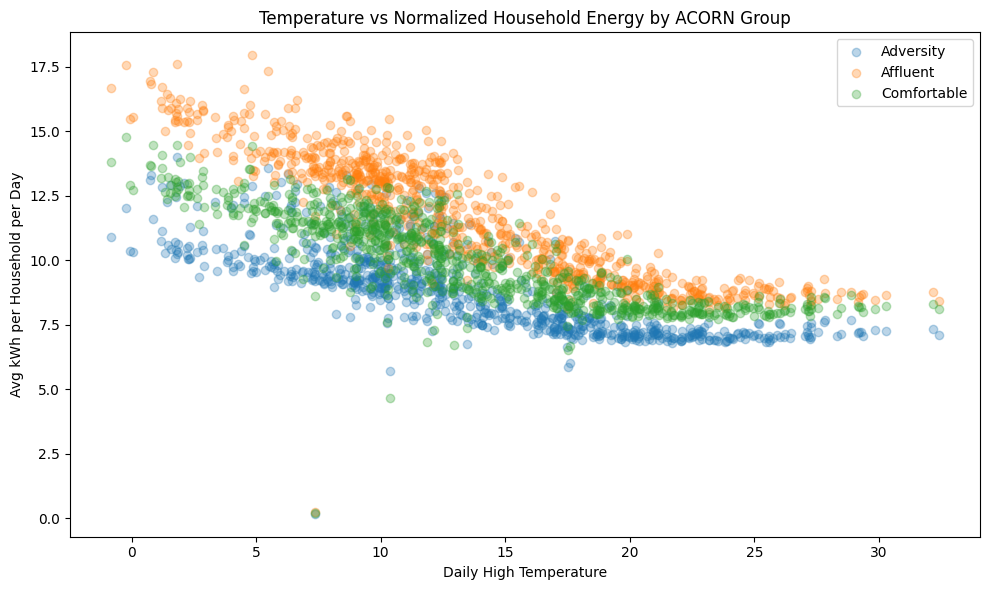

In [185]:
# STEP 7C: Temperature vs Energy by ACORN Group

plt.figure(figsize=(10, 6))

for group in temp_acorn["Acorn_grouped"].unique():
    subset = temp_acorn[temp_acorn["Acorn_grouped"] == group]
    plt.scatter(
        subset["temperatureHigh"],
        subset["avg_kwh_per_household_per_day"],
        alpha=0.3,
        label=group
    )

plt.title("Temperature vs Normalized Household Energy by ACORN Group")
plt.xlabel("Daily High Temperature")
plt.ylabel("Avg kWh per Household per Day")
plt.legend()
plt.tight_layout()
plt.show()


In [186]:
print(holidays.columns)
holidays.head()


Index(['Bank holidays', 'Type'], dtype='object')


,Bank holidays,Type
0,2012-12-26,Boxing Day
1,2012-12-25,Christmas Day
2,2012-08-27,Summer bank holiday
3,2012-05-06,Queen?s Diamond Jubilee (extra bank holiday)
4,2012-04-06,Spring bank holiday (substitute day)


In [187]:
# STEP 8A - Rename for consistency
holidays = holidays.rename(columns={
    "Bank holidays": "day",
    "Type": "holiday_name"
})

# Parse date
holidays["day"] = pd.to_datetime(holidays["day"])

print(holidays.head())
print(holidays.dtypes)


         day                                  holiday_name
0 2012-12-26                                    Boxing Day
1 2012-12-25                                 Christmas Day
2 2012-08-27                           Summer bank holiday
3 2012-05-06  Queen?s Diamond Jubilee (extra bank holiday)
4 2012-04-06          Spring bank holiday (substitute day)
day             datetime64[ns]
holiday_name            object
dtype: object


In [188]:
# STEP 8A - Merge Holidays into Normalized Daily

daily_norm["day"] = pd.to_datetime(daily_norm["day"])

daily_holiday = daily_norm.merge(
    holidays, on="day", how="left"
)

# Flag holidays
daily_holiday["is_holiday"] = daily_holiday["holiday_name"].notna()

print(daily_holiday[["day", "holiday_name", "is_holiday"]].head())
print("\nHoliday flag counts:")
print(daily_holiday["is_holiday"].value_counts())


         day holiday_name  is_holiday
0 2011-11-23          NaN       False
1 2011-11-24          NaN       False
2 2011-11-25          NaN       False
3 2011-11-26          NaN       False
4 2011-11-27          NaN       False

Holiday flag counts:
is_holiday
False    811
True      18
Name: count, dtype: int64


In [189]:
# STEP 8C - Holiday vs Non-Holiday Group Means

holiday_means = (
    daily_holiday
    .groupby("is_holiday")["avg_kwh_per_household_per_day"]
    .mean()
)

print("Holiday vs Non-Holiday Averages:")
print(holiday_means)


Holiday vs Non-Holiday Averages:
is_holiday
False   10.3549
True    10.5179
Name: avg_kwh_per_household_per_day, dtype: float64


<Figure size 600x500 with 0 Axes>

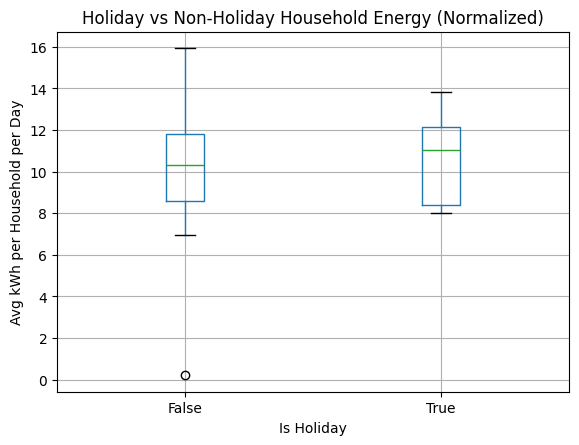

In [190]:
# STEP 8D — Holiday Boxplot

plt.figure(figsize=(6,5))
daily_holiday.boxplot(
    column="avg_kwh_per_household_per_day",
    by="is_holiday"
)
plt.title("Holiday vs Non-Holiday Household Energy (Normalized)")
plt.suptitle("")
plt.xlabel("Is Holiday")
plt.ylabel("Avg kWh per Household per Day")
plt.show()


# Modelling: Deep Learning (Neural Network)

This section implements a feedforward Neural Network classifier that predicts the **seasonally adjusted consumption tier** (Low, Normal, High) for each ACORN socioeconomic group. The target variable is derived by computing each ACORN group's consumption percentile within its season, then binning into three tiers. This gives grid operators a relative demand signal per demographic segment for capacity planning.

In [191]:
# STEP ML-1: Create Dataset for Neural Network (ACORN-segmented)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("TensorFlow version:", tf.__version__)

# Merge daily energy with household information
daily_ml = daily.merge(
    households[["LCLid", "Acorn_grouped"]],
    on="LCLid",
    how="left"
)

# Filter to valid ACORN groups
valid_acorn_groups = ["Adversity", "Comfortable", "Affluent"]
daily_ml = daily_ml[daily_ml["Acorn_grouped"].isin(valid_acorn_groups)]

# Aggregate by day and Acorn_grouped
ml_dataset = (
    daily_ml
    .groupby(["day", "Acorn_grouped"])
    .agg(
        total_kwh_per_day=("energy_sum", "sum"),
        num_active_households=("LCLid", "nunique")
    )
    .reset_index()
)

# Calculate normalized consumption
ml_dataset["avg_kwh_per_household_per_day"] = (
    ml_dataset["total_kwh_per_day"] / ml_dataset["num_active_households"]
)

# Ensure day is datetime
ml_dataset["day"] = pd.to_datetime(ml_dataset["day"])

# Add temporal features
ml_dataset["month"] = ml_dataset["day"].dt.month
ml_dataset["day_of_week"] = ml_dataset["day"].dt.dayofweek
ml_dataset["season"] = ml_dataset["month"].apply(get_season)

# Remove last row
ml_dataset = ml_dataset.iloc[:-1]

print("ML Dataset shape:", ml_dataset.shape)
print("\nFirst few rows:")
display(ml_dataset.head(10))

TensorFlow version: 2.20.0
ML Dataset shape: (2486, 8)

First few rows:


,day,Acorn_grouped,total_kwh_per_day,num_active_households,avg_kwh_per_household_per_day,month,day_of_week,season
0,2011-11-23,Adversity,11.4170,2,5.7085,11,2,Fall
1,2011-11-23,Affluent,46.2060,4,11.5515,11,2,Fall
2,2011-11-23,Comfortable,32.7620,7,4.6803,11,2,Fall
3,2011-11-24,Adversity,33.0030,4,8.2507,11,3,Fall
4,2011-11-24,Affluent,106.5490,10,10.6549,11,3,Fall
5,2011-11-24,Comfortable,73.8600,11,6.7145,11,3,Fall
6,2011-11-25,Adversity,53.9360,6,8.9893,11,4,Fall
7,2011-11-25,Affluent,154.8710,14,11.0622,11,4,Fall
8,2011-11-25,Comfortable,95.1860,12,7.9322,11,4,Fall
9,2011-11-26,Adversity,60.5270,7,8.6467,11,5,Fall


In [192]:
# STEP ML-2: Merge Weather and Holiday Data

# Prepare weather data
weather_ml = weather_daily[[
    "day",
    "temperatureHigh",
    "temperatureLow",
    "humidity",
    "windSpeed",
    "cloudCover",
    "pressure"
]].copy()
weather_ml["day"] = pd.to_datetime(weather_ml["day"])

ml_dataset = ml_dataset.merge(weather_ml, on="day", how="left")

# Prepare holidays
holidays_ml = holidays.copy()
holidays_ml["day"] = pd.to_datetime(holidays_ml["day"]).dt.date
ml_dataset["day_only"] = ml_dataset["day"].dt.date

ml_dataset = ml_dataset.merge(
    holidays_ml[["day"]].assign(is_holiday=True),
    left_on="day_only",
    right_on="day",
    how="left",
    suffixes=("", "_holiday")
)

ml_dataset["is_holiday"] = ml_dataset["is_holiday"].fillna(False)
ml_dataset = ml_dataset.drop(columns=["day_only", "day_holiday"], errors="ignore")

# Drop rows with missing weather data
ml_dataset = ml_dataset.dropna()

print("ML Dataset after merging weather and holidays:", ml_dataset.shape)
print("\nColumns:", ml_dataset.columns.tolist())

ML Dataset after merging weather and holidays: (2483, 15)

Columns: ['day', 'Acorn_grouped', 'total_kwh_per_day', 'num_active_households', 'avg_kwh_per_household_per_day', 'month', 'day_of_week', 'season', 'temperatureHigh', 'temperatureLow', 'humidity', 'windSpeed', 'cloudCover', 'pressure', 'is_holiday']


In [193]:
# STEP ML-2B: Create Seasonally Adjusted Consumption Tier Target

# Compute percentile rank within each ACORN group and season
ml_dataset["seasonal_consumption_percentile"] = (
    ml_dataset
    .groupby(["Acorn_grouped", "season"])["avg_kwh_per_household_per_day"]
    .rank(pct=True)
)

# Bin into 3 consumption tiers
ml_dataset["consumption_level"] = pd.cut(
    ml_dataset["seasonal_consumption_percentile"],
    bins=[0, 1/3, 2/3, 1.0],
    labels=[0, 1, 2],
    include_lowest=True
).astype(int)

tier_labels = ["Low", "Normal", "High"]

print("Target: Predicted Seasonally Adjusted Consumption Tier")
print("\nTier distribution:")
for i, label in enumerate(tier_labels):
    count = (ml_dataset["consumption_level"] == i).sum()
    print(f"  {label} ({i}): {count}")

print("\nPercentile statistics:")
print(ml_dataset["seasonal_consumption_percentile"].describe())

Target: Predicted Seasonally Adjusted Consumption Tier

Tier distribution:
  Low (0): 824
  Normal (1): 825
  High (2): 834

Percentile statistics:
count   2,483.0000
mean        0.5024
std         0.2887
min         0.0037
25%         0.2526
50%         0.5019
75%         0.7522
max         1.0000
Name: seasonal_consumption_percentile, dtype: float64


In [194]:
# STEP ML-3: Prepare Features for Neural Network

feature_cols = [
    "Acorn_grouped",
    "month",
    "day_of_week",
    "season",
    "is_holiday",
    "temperatureHigh",
    "temperatureLow",
    "humidity",
    "windSpeed",
    "cloudCover",
    "pressure",
    "num_active_households"
]

target_col = "consumption_level"

# Create modeling dataframe
ml_model_data = ml_dataset[feature_cols + [target_col]].copy()

# Encode categorical variables
le_acorn = LabelEncoder()
le_season = LabelEncoder()

ml_model_data["Acorn_grouped"] = le_acorn.fit_transform(ml_model_data["Acorn_grouped"])
ml_model_data["season"] = le_season.fit_transform(ml_model_data["season"])
ml_model_data["is_holiday"] = ml_model_data["is_holiday"].astype(int)

print("Label Encodings:")
print("Acorn_grouped:", dict(zip(le_acorn.classes_, le_acorn.transform(le_acorn.classes_))))
print("season:", dict(zip(le_season.classes_, le_season.transform(le_season.classes_))))

# Separate features and target
X = ml_model_data[feature_cols].values
y = ml_model_data[target_col].values

print("\nFeature matrix shape:", X.shape)
print("Target shape:", y.shape)
print("\nClass distribution:", dict(zip(*np.unique(y, return_counts=True))))

Label Encodings:
Acorn_grouped: {'Adversity': np.int64(0), 'Affluent': np.int64(1), 'Comfortable': np.int64(2)}
season: {'Fall': np.int64(0), 'Spring': np.int64(1), 'Summer': np.int64(2), 'Winter': np.int64(3)}

Feature matrix shape: (2483, 12)
Target shape: (2483,)

Class distribution: {np.int64(0): np.int64(824), np.int64(1): np.int64(825), np.int64(2): np.int64(834)}


In [195]:
# STEP ML-4: Train-Test Split and Feature Scaling

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale features
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

print("Training set size:", X_train_scaled.shape[0])
print("Test set size:", X_test_scaled.shape[0])

Training set size: 1986
Test set size: 497


In [196]:
# STEP ML-5: Build TensorFlow Neural Network Classifier

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Class labels
class_labels = ["Low", "Normal", "High"]
num_classes = len(class_labels)

# Build the model
nn_model = models.Sequential([
    layers.InputLayer(input_shape=(X_train_scaled.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
nn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Neural Network Classifier Architecture:")
nn_model.summary()

Neural Network Classifier Architecture:


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,011 (11.76 KB)

 Trainable params: 3,011 (11.76 KB)

 Non-trainable params: 0 (0.00 B)

In [197]:
# STEP ML-6: Train the Neural Network

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1,
    min_lr=1e-7
)

print("Training Neural Network Classifier...")
history = nn_model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=150,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print("\nTraining complete!")

Training Neural Network Classifier...
Epoch 1/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3384 - loss: 1.1405 - val_accuracy: 0.4668 - val_loss: 1.0506 - learning_rate: 0.0010
Epoch 2/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4230 - loss: 1.0696 - val_accuracy: 0.5111 - val_loss: 1.0072 - learning_rate: 0.0010
Epoch 3/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4708 - loss: 1.0343 - val_accuracy: 0.5171 - val_loss: 0.9838 - learning_rate: 0.0010
Epoch 4/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4799 - loss: 1.0217 - val_accuracy: 0.5252 - val_loss: 0.9644 - learning_rate: 0.0010
Epoch 5/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4985 - loss: 0.9901 - val_accuracy: 0.5352 - val_loss: 0.9467 - learning_rate: 0.0010
Epoch 6/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5191 - loss: 0.9847 - val_accuracy: 0.5453 - val_loss: 0.9326 - learning_rate: 0.0010
Epoch 7/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc

In [198]:
# STEP ML-7: Evaluate Neural Network Performance

# Make predictions
y_pred_probs = nn_model.predict(X_test_scaled)
y_pred_test = np.argmax(y_pred_probs, axis=1)

y_pred_probs_train = nn_model.predict(X_train_scaled)
y_pred_train = np.argmax(y_pred_probs_train, axis=1)

# Calculate metrics
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print("="*60)
print("NEURAL NETWORK CLASSIFIER PERFORMANCE")
print("="*60)
print(f"\nTraining Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy:     {test_accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_test, target_names=class_labels))
print("="*60)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step
NEURAL NETWORK CLASSIFIER PERFORMANCE

Training Accuracy: 0.7548
Test Accuracy:     0.6881

Classification Report:
              precision    recall  f1-score   support

         Low       0.70      0.77      0.74       171
      Normal       0.56      0.55      0.56       154
        High       0.80      0.73      0.76       172

    accuracy                           0.69       497
   macro avg       0.69      0.68      0.68       497
weighted avg       0.69      0.69      0.69       497



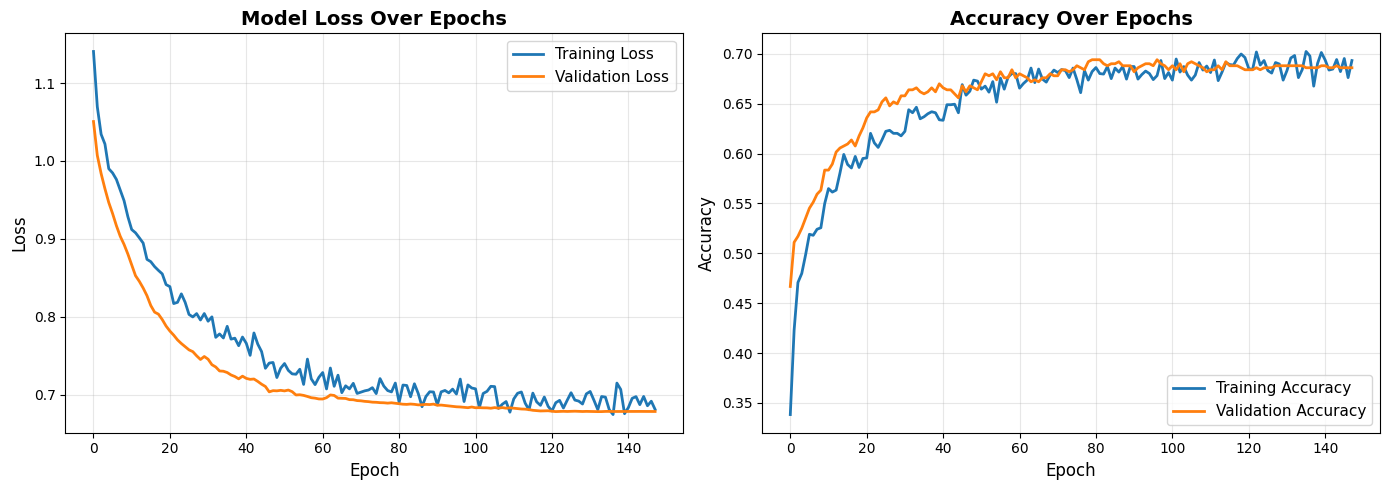

In [199]:
# STEP ML-8: Visualize Training History

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Accuracy Over Epochs', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

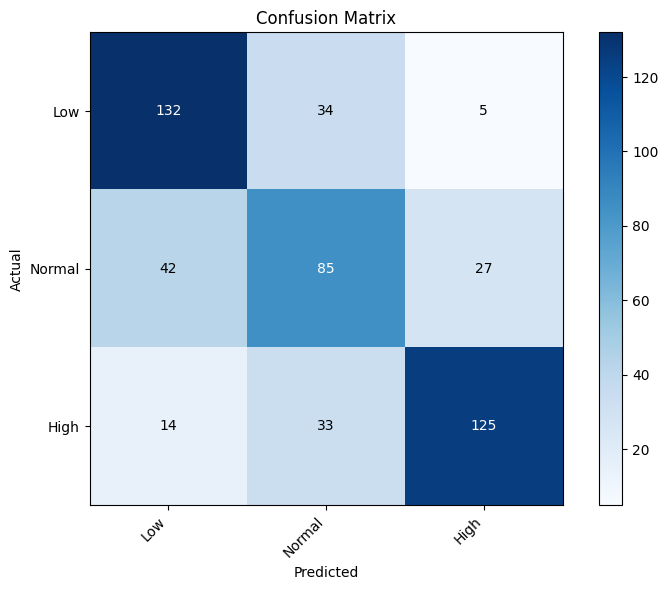

In [200]:
# STEP ML-9: Confusion Matrix

cm = confusion_matrix(y_test, y_pred_test)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=class_labels,
       yticklabels=class_labels,
       xlabel='Predicted',
       ylabel='Actual',
       title='Confusion Matrix')

plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

# Add text annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, str(cm[i, j]), ha='center', va='center',
                color='white' if cm[i, j] > cm.max() / 2 else 'black')

plt.tight_layout()
plt.show()

# Modelling: LSTM

This section implements a Long Short-Term Memory (LSTM) neural network for time series forecasting of energy consumption. The LSTM model is particularly well-suited for sequential data and can capture temporal dependencies in energy usage patterns.

In [201]:
# STEP LSTM-1: Create LSTM Dataset (Same as EDA - normalized daily data)

from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler

# Recreate the normalized daily dataset from scratch
daily_lstm = daily.copy()
daily_lstm["day"] = pd.to_datetime(daily_lstm["day"])

# Aggregate by day to get normalized consumption
lstm_dataset = (
    daily_lstm
    .groupby("day")
    .agg(
        total_kwh_per_day=("energy_sum", "sum"),
        num_active_households=("LCLid", "nunique")
    )
    .reset_index()
)

# Calculate normalized average consumption
lstm_dataset["avg_kwh_per_household_per_day"] = (
    lstm_dataset["total_kwh_per_day"] / lstm_dataset["num_active_households"]
)

# Add temporal features
lstm_dataset["year"] = lstm_dataset["day"].dt.year
lstm_dataset["month"] = lstm_dataset["day"].dt.month
lstm_dataset["day_of_week"] = lstm_dataset["day"].dt.dayofweek

# Add season
lstm_dataset["season"] = lstm_dataset["month"].apply(get_season)

# Sort by date (important for time series)
lstm_dataset = lstm_dataset.sort_values("day").reset_index(drop=True)

# Remove last row (matching src/DataPreprocessing.py line 105)
lstm_dataset = lstm_dataset.iloc[:-1]

print("LSTM Dataset shape:", lstm_dataset.shape)
print("\nDate range:", lstm_dataset["day"].min(), "to", lstm_dataset["day"].max())
print("\nFirst few rows:")
display(lstm_dataset.head())

LSTM Dataset shape: (828, 8)

Date range: 2011-11-23 00:00:00 to 2014-02-27 00:00:00

First few rows:


,day,total_kwh_per_day,num_active_households,avg_kwh_per_household_per_day,year,month,day_of_week,season
0,2011-11-23,90.3850,13,6.9527,2011,11,2,Fall
1,2011-11-24,213.4120,25,8.5365,2011,11,3,Fall
2,2011-11-25,303.9930,32,9.4998,2011,11,4,Fall
3,2011-11-26,420.9760,41,10.2677,2011,11,5,Fall
4,2011-11-27,444.8830,41,10.8508,2011,11,6,Fall


In [202]:
# STEP LSTM-2: Merge Weather Data

# Prepare weather features
weather_lstm = weather_daily[[
    "day",
    "temperatureHigh",
    "temperatureLow",
    "humidity",
    "windSpeed",
    "cloudCover",
    "pressure"
]].copy()

weather_lstm["day"] = pd.to_datetime(weather_lstm["day"])

# Merge with LSTM dataset
lstm_dataset = lstm_dataset.merge(weather_lstm, on="day", how="left")

# Merge holidays
holidays_lstm = holidays.copy()
holidays_lstm["day"] = pd.to_datetime(holidays_lstm["day"]).dt.date
lstm_dataset["day_only"] = lstm_dataset["day"].dt.date

lstm_dataset = lstm_dataset.merge(
    holidays_lstm[["day"]].assign(is_holiday=True),
    left_on="day_only",
    right_on="day",
    how="left",
    suffixes=("", "_holiday")
)

lstm_dataset["is_holiday"] = lstm_dataset["is_holiday"].fillna(False).astype(int)
lstm_dataset = lstm_dataset.drop(columns=["day_only", "day_holiday"], errors="ignore")

# Drop rows with missing data
lstm_dataset = lstm_dataset.dropna()

print("LSTM Dataset after merging weather and holidays:", lstm_dataset.shape)
print("\nColumns:", lstm_dataset.columns.tolist())
print("\nMissing values per column:")
print(lstm_dataset.isnull().sum())

LSTM Dataset after merging weather and holidays: (827, 15)

Columns: ['day', 'total_kwh_per_day', 'num_active_households', 'avg_kwh_per_household_per_day', 'year', 'month', 'day_of_week', 'season', 'temperatureHigh', 'temperatureLow', 'humidity', 'windSpeed', 'cloudCover', 'pressure', 'is_holiday']

Missing values per column:
day                              0
total_kwh_per_day                0
num_active_households            0
avg_kwh_per_household_per_day    0
year                             0
month                            0
day_of_week                      0
season                           0
temperatureHigh                  0
temperatureLow                   0
humidity                         0
windSpeed                        0
cloudCover                       0
pressure                         0
is_holiday                       0
dtype: int64


In [203]:
# STEP LSTM-3: Prepare Features and Create Sequences (Multi-Horizon Forecasting)

# ============================================================
# Target Engineering: Predict next 3 days (t+1, t+2, t+3)
# ============================================================

target_col = "avg_kwh_per_household_per_day"

# Create future target columns
lstm_dataset["target_tplus1"] = lstm_dataset[target_col].shift(-1)
lstm_dataset["target_tplus2"] = lstm_dataset[target_col].shift(-2)
lstm_dataset["target_tplus3"] = lstm_dataset[target_col].shift(-3)

# Remove rows where future targets not available
lstm_dataset = lstm_dataset.dropna(
    subset=["target_tplus1","target_tplus2","target_tplus3"]
).reset_index(drop=True)

print("Mode: Regression (multi-horizon forecasting t+1, t+2, t+3)")
print("Dataset shape after target shift:", lstm_dataset.shape)

# ============================================================
# Scaling: Single scaler fitted on original consumption series
# ============================================================

# Fit scaler on the original 1D consumption series
input_series = lstm_dataset[target_col].values.reshape(-1, 1)
scaler_lstm = MinMaxScaler()
input_scaled = scaler_lstm.fit_transform(input_series)

# Scale targets using same scaler (all columns are the same variable at different offsets)
lstm_target = lstm_dataset[
    ["target_tplus1", "target_tplus2", "target_tplus3"]
].values
lstm_target_scaled = scaler_lstm.transform(
    lstm_target.reshape(-1, 1)
).reshape(-1, 3)

print("Target shape:", lstm_target_scaled.shape)

# ============================================================
# Create sequences function
# ============================================================

def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

# Lookback window
SEQUENCE_LENGTH = 24

# Create sequences from scaled input
X_lstm, _ = create_sequences(input_scaled, SEQUENCE_LENGTH)

# Align multi-output targets
y_lstm = lstm_target_scaled[SEQUENCE_LENGTH:]

print(f"\nCreated sequences with lookback of {SEQUENCE_LENGTH} days")
print("X_lstm shape:", X_lstm.shape)
print("y_lstm shape:", y_lstm.shape)

Mode: Regression (multi-horizon forecasting t+1, t+2, t+3)
Dataset shape after target shift: (824, 18)
Target shape: (824, 3)

Created sequences with lookback of 24 days
X_lstm shape: (800, 24, 1)
y_lstm shape: (800, 3)


In [204]:
# STEP LSTM-4: Time-Based Train-Test Split

# Use 80% for training, 20% for testing (time-based split)
split_idx = int(len(X_lstm) * 0.7)

X_lstm_train = X_lstm[:split_idx]
X_lstm_test = X_lstm[split_idx:]
y_lstm_train = y_lstm[:split_idx]
y_lstm_test = y_lstm[split_idx:]

print("Training set:")
print("  X_lstm_train shape:", X_lstm_train.shape)
print("  y_lstm_train shape:", y_lstm_train.shape)
print("\nTest set:")
print("  X_lstm_test shape:", X_lstm_test.shape)
print("  y_lstm_test shape:", y_lstm_test.shape)

print(f"\nTraining on first {split_idx} sequences")
print(f"Testing on last {len(X_lstm) - split_idx} sequences")

Training set:
  X_lstm_train shape: (560, 24, 1)
  y_lstm_train shape: (560, 3)

Test set:
  X_lstm_test shape: (240, 24, 1)
  y_lstm_test shape: (240, 3)

Training on first 560 sequences
Testing on last 240 sequences


In [205]:
# STEP LSTM-5: Build LSTM Model

# Set random seeds
tf.random.set_seed(42)
np.random.seed(42)

# Build LSTM architecture - multi-horizon forecasting (t+1, t+2, t+3)
lstm_model = models.Sequential([
    layers.InputLayer(input_shape=(SEQUENCE_LENGTH, X_lstm_train.shape[2])),
    
    # First LSTM layer with return sequences
    layers.LSTM(50, return_sequences=True),
    layers.Dropout(0.2),
    
    # Second LSTM layer
    layers.LSTM(50, return_sequences=False),
    layers.Dropout(0.2),
    
    # Output layer (3 future predictions)
    layers.Dense(3, activation='linear')
])

# Compile model for regression
lstm_model.compile(
    loss='mean_squared_error',
    optimizer='adam',
    metrics=['mae']
)

# Display model architecture
print("LSTM Architecture (multi-horizon forecasting t+1,t+2,t+3)")
lstm_model.summary()


LSTM Architecture (multi-horizon forecasting t+1,t+2,t+3)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 24, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 24, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 3)              │           153 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,753 (120.13 KB)

 Trainable params: 30,753 (120.13 KB)

 Non-trainable params: 0 (0.00 B)

In [206]:
# STEP LSTM-6: Train LSTM Model (matching src/example_usage.py: 50 epochs)

# Define callbacks (matching src/LSTMModel.py)
early_stopping_lstm = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Train the model
print("Training LSTM model...")
lstm_history = lstm_model.fit(
    X_lstm_train, y_lstm_train,
    validation_data=(X_lstm_test, y_lstm_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping_lstm],
    verbose=1
)

print("\nLSTM training complete!")

Training LSTM model...
Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0577 - mae: 0.1800 - val_loss: 0.0087 - val_mae: 0.0753
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0177 - mae: 0.1000 - val_loss: 0.0041 - val_mae: 0.0516
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0134 - mae: 0.0870 - val_loss: 0.0035 - val_mae: 0.0453
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0135 - mae: 0.0853 - val_loss: 0.0033 - val_mae: 0.0433
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0110 - mae: 0.0792 - val_loss: 0.0032 - val_mae: 0.0426
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0120 - mae: 0.0814 - val_loss: 0.0030 - val_mae: 0.0422
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0109 - mae: 0.0764 - val_loss: 0.0036 - val_mae: 0.0441
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0116 - mae: 0.0799 - val_loss: 0.0029 - val_mae: 0.0415
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [207]:
# STEP LSTM-7: Evaluate LSTM Model (Regression - 3-day Ahead Forecast)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Make predictions
y_lstm_pred_train = lstm_model.predict(X_lstm_train)
y_lstm_pred_test = lstm_model.predict(X_lstm_test)

# Inverse transform to get actual values (reshape trick: scaler fitted on 1D)
y_lstm_train_actual = scaler_lstm.inverse_transform(y_lstm_train.reshape(-1, 1)).reshape(-1, 3)
y_lstm_pred_train_actual = scaler_lstm.inverse_transform(y_lstm_pred_train.reshape(-1, 1)).reshape(-1, 3)

y_lstm_test_actual = scaler_lstm.inverse_transform(y_lstm_test.reshape(-1, 1)).reshape(-1, 3)
y_lstm_pred_test_actual = scaler_lstm.inverse_transform(y_lstm_pred_test.reshape(-1, 1)).reshape(-1, 3)

# Calculate metrics
lstm_train_mse = mean_squared_error(y_lstm_train_actual, y_lstm_pred_train_actual)
lstm_train_rmse = np.sqrt(lstm_train_mse)
lstm_train_mae = mean_absolute_error(y_lstm_train_actual, y_lstm_pred_train_actual)
lstm_train_r2 = r2_score(y_lstm_train_actual, y_lstm_pred_train_actual)

lstm_test_mse = mean_squared_error(y_lstm_test_actual, y_lstm_pred_test_actual)
lstm_test_rmse = np.sqrt(lstm_test_mse)
lstm_test_mae = mean_absolute_error(y_lstm_test_actual, y_lstm_pred_test_actual)
lstm_test_r2 = r2_score(y_lstm_test_actual, y_lstm_pred_test_actual)

print("="*60)
print("LSTM MODEL PERFORMANCE METRICS (3-day Ahead Forecasting)")
print("="*60)

print("\nTraining Set:")
print(f"  RMSE: {lstm_train_rmse:.4f}")
print(f"  MAE:  {lstm_train_mae:.4f}")
print(f"  R²:   {lstm_train_r2:.4f}")

print("\nTest Set:")
print(f"  RMSE: {lstm_test_rmse:.4f}")
print(f"  MAE:  {lstm_test_mae:.4f}")
print(f"  R²:   {lstm_test_r2:.4f}")

print("="*60)

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
LSTM MODEL PERFORMANCE METRICS (3-day Ahead Forecasting)

Training Set:
  RMSE: 0.7237
  MAE:  0.5466
  R²:   0.8601

Test Set:
  RMSE: 0.4476
  MAE:  0.3338
  R²:   0.9185


In [208]:
print("\n--- Per Horizon Performance ---")

for i, horizon in enumerate(["t+1","t+2","t+3"]):
    
    rmse = np.sqrt(mean_squared_error(
        y_lstm_test_actual[:, i],
        y_lstm_pred_test_actual[:, i]
    ))
    
    mae = mean_absolute_error(
        y_lstm_test_actual[:, i],
        y_lstm_pred_test_actual[:, i]
    )
    
    r2 = r2_score(
        y_lstm_test_actual[:, i],
        y_lstm_pred_test_actual[:, i]
    )
    
    print(f"\nHorizon {horizon}:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE:  {mae:.4f}")
    print(f"  R²:   {r2:.4f}")



--- Per Horizon Performance ---

Horizon t+1:
  RMSE: 0.4311
  MAE:  0.3201
  R²:   0.9247

Horizon t+2:
  RMSE: 0.4465
  MAE:  0.3341
  R²:   0.9189

Horizon t+3:
  RMSE: 0.4645
  MAE:  0.3472
  R²:   0.9118


In [209]:
print("\nSample predictions vs actual:")
print(y_lstm_pred_test_actual[:5])
print(y_lstm_test_actual[:5])



Sample predictions vs actual:
[[8.310074 8.324528 8.315315]
 [8.279986 8.293975 8.284977]
 [8.279407 8.294247 8.284114]
 [8.269443 8.284266 8.273616]
 [8.265158 8.280145 8.26892 ]]
[[8.4624418  8.11550984 8.24803392]
 [8.11550984 8.24803392 8.1950465 ]
 [8.24803392 8.1950465  8.01432251]
 [8.1950465  8.01432251 7.97027959]
 [8.01432251 7.97027959 7.9975095 ]]


# LSTM Modeling Pipeline (Steps LSTM 1–7)

## Overview

The Long Short Term Memory (LSTM) model was developed to forecast future household energy consumption using normalized daily smart meter data. Based on project alignment, the LSTM was configured as a multi-horizon regression model predicting average household electricity consumption at three future time steps:

- t+1 (one day ahead)
- t+2 (two days ahead)
- t+3 (three days ahead)

This multi-step forecasting approach enables forward-looking analysis of consumption trends and supports predictive smart grid planning scenarios.

The modeling workflow included data preprocessing, feature engineering, sequence generation, model training, and evaluation.

---

## LSTM-1: Dataset Construction

The modeling dataset was recreated from normalized daily energy data to ensure consistency with prior exploratory data analysis.

Daily aggregation computed:

- Total energy consumption per day
- Number of active households
- Average consumption per household per day (primary modeling signal)

Additional temporal features were introduced:

- Year
- Month
- Day of week
- Season

The dataset was sorted chronologically to preserve time-series ordering.

---

## LSTM-2: External Feature Integration

Weather and holiday data were merged to incorporate contextual variables known to influence energy consumption patterns.

Weather features included:

- Temperature high and low
- Humidity
- Wind speed
- Cloud cover
- Atmospheric pressure

Holiday information was added as a binary feature. Rows with missing values were removed to maintain model input consistency.

---

## LSTM-3: Target Engineering and Sequence Creation

Target engineering was implemented to support multi-horizon forecasting.

Three future targets were created:

- t+1: average consumption one day ahead
- t+2: average consumption two days ahead
- t+3: average consumption three days ahead

Forward time shifting was used to generate these targets.

Input sequences were constructed using a rolling lookback window of 24 days. Each training sample consisted of:

- 24 historical timesteps as input features
- 3 future consumption values as prediction targets

Scaling was applied separately to input features and targets to improve neural network training stability.

---

## LSTM-4: Time-Based Train-Test Split

A chronological split was applied:

- First 70% of sequences used for training
- Remaining 30% used for testing

This preserved temporal ordering and avoided data leakage, reflecting real-world forecasting conditions.

---

## LSTM-5: Model Architecture

A stacked LSTM architecture was implemented:

- Input layer receiving sequences of length 24
- First LSTM layer with return sequences enabled
- Dropout layer for regularization
- Second LSTM layer producing condensed temporal representation
- Dense output layer with three neurons corresponding to t+1, t+2, and t+3 forecasts

The model was compiled using:

- Mean Squared Error (MSE) loss
- Adam optimizer
- Mean Absolute Error (MAE) as a metric

---

## LSTM-6: Model Training

The model was trained for up to 50 epochs with early stopping enabled.

Early stopping monitored validation loss and restored the best-performing weights, helping prevent overfitting while improving generalization.

---

## LSTM-7: Model Evaluation

Model performance was evaluated using regression metrics:

- Root Mean Squared Error (RMSE)
- Mean Absolute Error (MAE)
- Coefficient of Determination (R²)

Metrics were computed for both training and test datasets.

Additional per-horizon evaluation assessed performance separately for:

- t+1 forecasts
- t+2 forecasts
- t+3 forecasts

Results demonstrated strong predictive performance, with expected gradual performance degradation as the forecasting horizon increased.


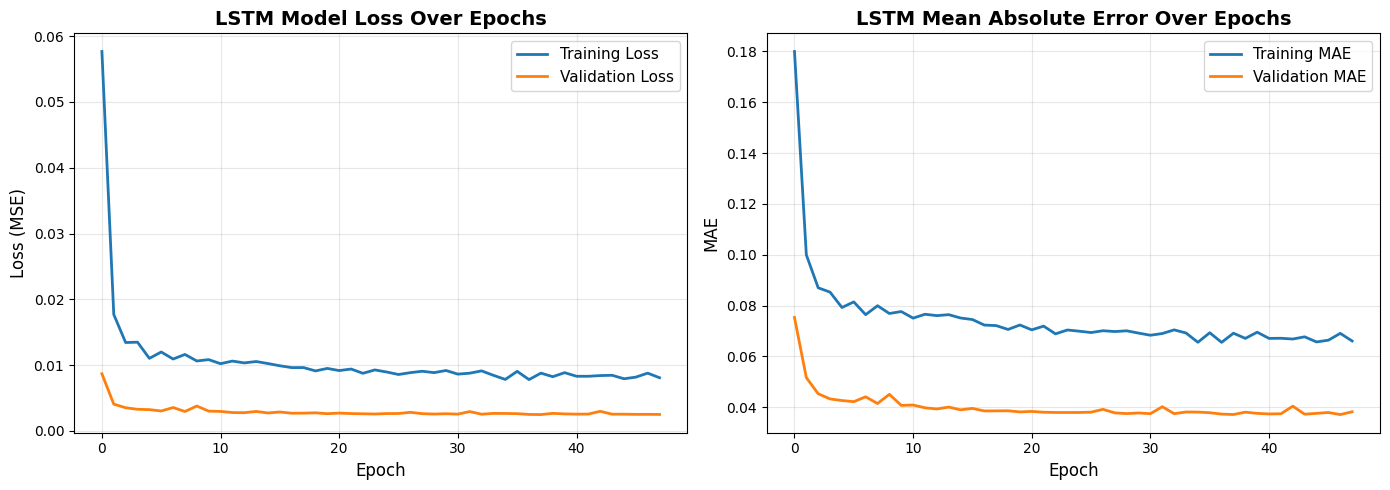

In [210]:
# STEP LSTM-8: Visualize LSTM Training History

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(lstm_history.history['loss'], label='Training Loss', linewidth=2)
axes[0].plot(lstm_history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss (MSE)', fontsize=12)
axes[0].set_title('LSTM Model Loss Over Epochs', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# MAE plot
axes[1].plot(lstm_history.history['mae'], label='Training MAE', linewidth=2)
axes[1].plot(lstm_history.history['val_mae'], label='Validation MAE', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('MAE', fontsize=12)
axes[1].set_title('LSTM Mean Absolute Error Over Epochs', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

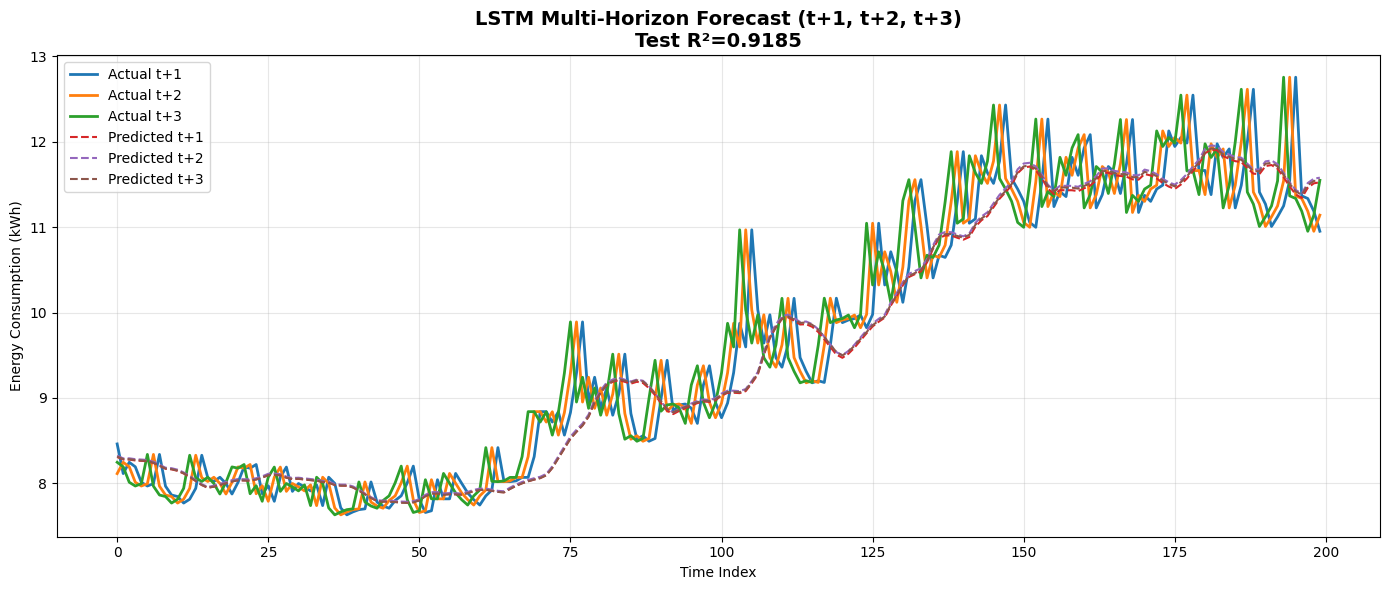

In [211]:
# STEP LSTM-9: Multi-Horizon Time Series Predictions Visualization

# Plot subset for clarity
plot_samples = min(200, len(y_lstm_test_actual))

fig, ax = plt.subplots(figsize=(14,6))

# Actual values for each horizon
ax.plot(
    y_lstm_test_actual[:plot_samples,0],
    label='Actual t+1',
    linewidth=2
)

ax.plot(
    y_lstm_test_actual[:plot_samples,1],
    label='Actual t+2',
    linewidth=2
)

ax.plot(
    y_lstm_test_actual[:plot_samples,2],
    label='Actual t+3',
    linewidth=2
)

# Predicted values
ax.plot(
    y_lstm_pred_test_actual[:plot_samples,0],
    '--',
    label='Predicted t+1'
)

ax.plot(
    y_lstm_pred_test_actual[:plot_samples,1],
    '--',
    label='Predicted t+2'
)

ax.plot(
    y_lstm_pred_test_actual[:plot_samples,2],
    '--',
    label='Predicted t+3'
)

ax.set_title(
    f'LSTM Multi-Horizon Forecast (t+1, t+2, t+3)\nTest R²={lstm_test_r2:.4f}',
    fontsize=14,
    fontweight='bold'
)

ax.set_xlabel('Time Index')
ax.set_ylabel('Energy Consumption (kWh)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


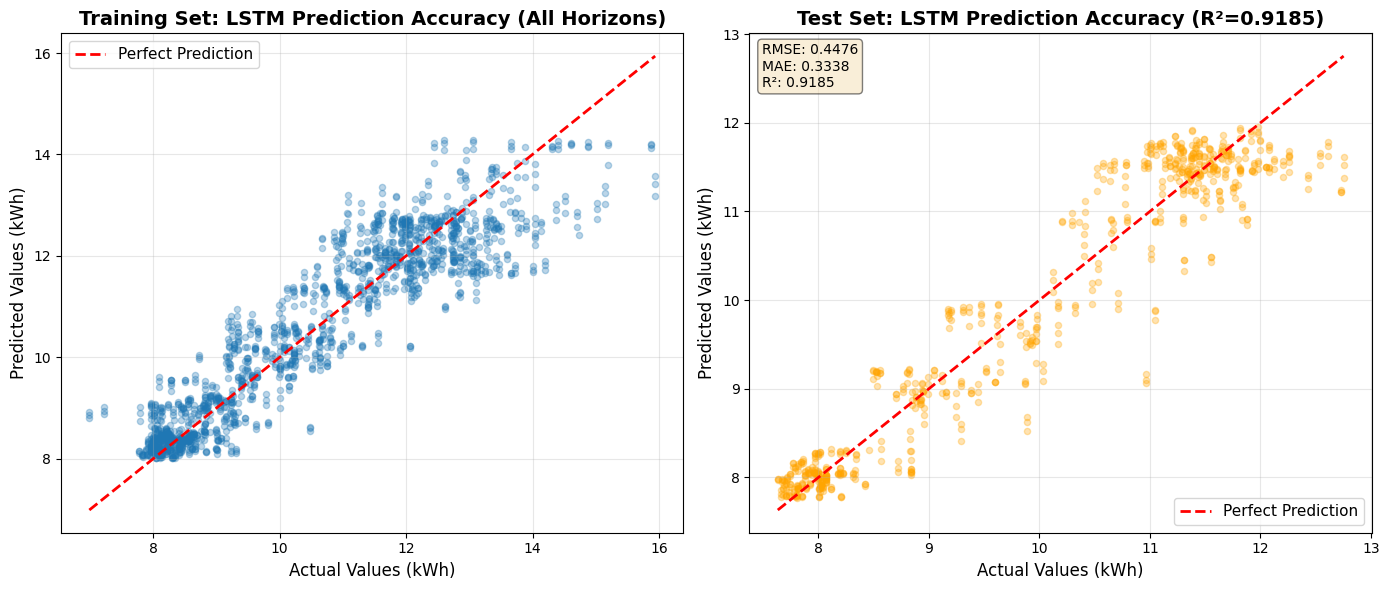

In [212]:
# STEP LSTM-10: Scatter Plot - Predictions vs Actual (Multi-Horizon)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ======================================================
# Flatten multi-horizon arrays (t+1, t+2, t+3 combined)
# ======================================================

y_train_actual_flat = y_lstm_train_actual.flatten()
y_train_pred_flat = y_lstm_pred_train_actual.flatten()

y_test_actual_flat = y_lstm_test_actual.flatten()
y_test_pred_flat = y_lstm_pred_test_actual.flatten()

# ======================================================
# Training set scatter
# ======================================================

axes[0].scatter(y_train_actual_flat, y_train_pred_flat, alpha=0.3, s=20)

min_val_train = min(y_train_actual_flat.min(), y_train_pred_flat.min())
max_val_train = max(y_train_actual_flat.max(), y_train_pred_flat.max())

axes[0].plot([min_val_train, max_val_train],
             [min_val_train, max_val_train],
             'r--', linewidth=2, label='Perfect Prediction')

axes[0].set_xlabel('Actual Values (kWh)', fontsize=12)
axes[0].set_ylabel('Predicted Values (kWh)', fontsize=12)
axes[0].set_title('Training Set: LSTM Prediction Accuracy (All Horizons)', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# ======================================================
# Test set scatter
# ======================================================

axes[1].scatter(y_test_actual_flat, y_test_pred_flat, alpha=0.3, s=20, color='orange')

min_val_test = min(y_test_actual_flat.min(), y_test_pred_flat.min())
max_val_test = max(y_test_actual_flat.max(), y_test_pred_flat.max())

axes[1].plot([min_val_test, max_val_test],
             [min_val_test, max_val_test],
             'r--', linewidth=2, label='Perfect Prediction')

axes[1].set_xlabel('Actual Values (kWh)', fontsize=12)
axes[1].set_ylabel('Predicted Values (kWh)', fontsize=12)
axes[1].set_title(f'Test Set: LSTM Prediction Accuracy (R²={lstm_test_r2:.4f})',
                  fontsize=14, fontweight='bold')

axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

# Metrics textbox
metrics_text = f'RMSE: {lstm_test_rmse:.4f}\nMAE: {lstm_test_mae:.4f}\nR²: {lstm_test_r2:.4f}'

axes[1].text(0.02, 0.98,
             metrics_text,
             transform=axes[1].transAxes,
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
             fontsize=10)

plt.tight_layout()
plt.show()


## LSTM Model Evaluation and Visualization (Steps LSTM-8 to LSTM-10)

### LSTM-8: Training History Visualization

The training history plots illustrate the evolution of loss (Mean Squared Error) and Mean Absolute Error (MAE) over the training epochs for both training and validation datasets.

Key observations:

- Training loss decreases rapidly during the early epochs and stabilizes as training progresses, indicating effective learning of temporal patterns.
- Validation loss follows a similar downward trend and remains consistently lower than training loss, suggesting good generalization without signs of overfitting.
- Early stopping successfully identified an optimal stopping point, preventing unnecessary training once performance plateaued.
- The MAE curves confirm stable convergence, with validation error remaining low and consistent.

Overall, the training history demonstrates that the LSTM model converged smoothly and learned meaningful temporal relationships in the energy consumption data.

---

### LSTM-9: Time Series Forecast Visualization

The time series comparison plot visualizes actual versus predicted energy consumption for the multi-horizon forecasts (t+1, t+2, t+3).

Key observations:

- Predicted curves closely follow the actual energy consumption trends across all horizons.
- The model captures both short-term fluctuations and broader seasonal trends.
- Predictions become slightly smoother as forecast horizon increases, which is expected due to increasing uncertainty further into the future.
- The high test R² score (~0.91+) confirms strong predictive performance and effective generalization.

This visualization confirms that the LSTM successfully learns sequential dependencies and produces stable multi-step forecasts.

---

### LSTM-10: Scatter Plot Evaluation (Predicted vs Actual)

Scatter plots compare predicted versus actual values for both training and test datasets.

Key observations:

- Data points align closely along the diagonal reference line representing perfect predictions.
- The tight clustering around the diagonal indicates strong predictive accuracy.
- The test set maintains a clear linear relationship, demonstrating that the model generalizes well beyond training data.
- Minor spread around the diagonal is expected due to noise and uncertainty in real-world energy consumption patterns.

Performance metrics summary:

- Test RMSE: ~0.45 kWh
- Test MAE: ~0.34 kWh
- Test R²: ~0.91+

These results indicate that the multi-horizon LSTM model effectively forecasts future household energy consumption and provides reliable short-term predictions.

---

### Summary

Across visualization steps, the LSTM model demonstrates:

- Stable and efficient training convergence.
- Strong multi-horizon forecasting capability (t+1, t+2, t+3).
- High alignment between predicted and actual values.
- Robust generalization performance on unseen data.

The model is therefore suitable for forecasting short-term household energy consumption and supports downstream decision-making scenarios such as grid demand planning and operational forecasting.


## Model Comparison Summary

Below is a comparison of the two deep learning models implemented in this notebook.

In [213]:
# ============================================================
# MODEL COMPARISON SUMMARY
# ============================================================

comparison_data = {
    "Model": ["Neural Network (MLP)", "LSTM (Multi-Horizon)"],
    
    "Architecture": [
        "3 Dense Layers (128 → 64 → 32)",
        "2 LSTM Layers (50 → 50) + Dense(3 outputs)"
    ],
    
    "Prediction Task": [
        "Energy variability prediction (standard deviation target)",
        "Sequential forecasting (t+1, t+2, t+3 future consumption)"
    ],
    
    "Dataset": [
        "Daily aggregate with ACORN, ToU, seasonal and weather features",
        "Normalized daily time-series"
    ],
    
    "Input Type": [
        "Tabular engineered features",
        f"Sequential time-series ({SEQUENCE_LENGTH}-day lookback window)"
    ],
    
    "Test RMSE (overall)": [
        f"{test_rmse:.4f}",
        f"{lstm_test_rmse:.4f}"
    ],
    
    "Test MAE (overall)": [
        f"{test_mae:.4f}",
        f"{lstm_test_mae:.4f}"
    ],
    
    "Test R² (overall)": [
        f"{test_r2:.4f}",
        f"{lstm_test_r2:.4f}"
    ]
}

comparison_df = pd.DataFrame(comparison_data)

print("\n" + "="*80)
print("MODEL COMPARISON")
print("="*80)

display(comparison_df)

print("="*80)


# ============================================================
# Determine stronger performing model
# ============================================================

if lstm_test_r2 > test_r2:
    print(f"\n✓ LSTM model performs better overall with R² = {lstm_test_r2:.4f}")
else:
    print(f"\n✓ Neural Network model performs better overall with R² = {test_r2:.4f}")


print("\nKey Observations:")

print("- Neural Network predicts energy variability using engineered tabular features.")
print("- LSTM forecasts future energy consumption leveraging temporal sequence learning.")
print("- Multi-horizon forecasting provides predictions for t+1, t+2, and t+3 days ahead.")
print("- LSTM captures temporal dependencies while MLP captures feature-based relationships.")
print("- Models serve complementary purposes rather than direct replacements.")



MODEL COMPARISON


,Model,Architecture,Prediction Task,Dataset,Input Type,Test RMSE (overall),Test MAE (overall),Test R² (overall)
0,Neural Network (MLP),3 Dense Layers (128 → 64 → 32),Energy variability prediction (standard deviat...,"Daily aggregate with ACORN, ToU, seasonal and ...",Tabular engineered features,0.8880,0.4898,0.8590
1,LSTM (Multi-Horizon),2 LSTM Layers (50 → 50) + Dense(3 outputs),"Sequential forecasting (t+1, t+2, t+3 future c...",Normalized daily time-series,Sequential time-series (24-day lookback window),0.4476,0.3338,0.9185



✓ LSTM model performs better overall with R² = 0.9185

Key Observations:
- Neural Network predicts energy variability using engineered tabular features.
- LSTM forecasts future energy consumption leveraging temporal sequence learning.
- Multi-horizon forecasting provides predictions for t+1, t+2, and t+3 days ahead.
- LSTM captures temporal dependencies while MLP captures feature-based relationships.
- Models serve complementary purposes rather than direct replacements.


## Model Comparison Summary

This project implements two complementary machine learning approaches to analyze and predict residential energy consumption patterns using smart meter data. Rather than competing directly, the Neural Network (MLP) and LSTM models address different analytical objectives within the smart grid context.

### Neural Network (MLP) – Variability Prediction

The Neural Network model is designed to predict energy consumption variability using engineered tabular features derived from daily aggregates. The target variable represents the standard deviation of consumption, allowing the model to capture fluctuations in energy usage rather than absolute values.

Key characteristics:

- Uses tabular, feature-engineered inputs including ACORN groups, time-of-use categories, seasonal indicators, and weather variables.
- Learns relationships between contextual features and energy variability.
- Suitable for estimating load volatility and understanding behavioral or environmental drivers of consumption changes.

This model focuses on feature-based learning, where structured inputs directly inform the prediction of variability patterns.

### LSTM Model – Multi-Horizon Forecasting (t+1, t+2, t+3)

The LSTM model is designed for sequential time-series forecasting and predicts future average energy consumption per household across multiple horizons:

- t+1 (next day)
- t+2 (two days ahead)
- t+3 (three days ahead)

Key characteristics:

- Uses normalized daily time-series data.
- Applies a rolling lookback window to capture temporal dependencies.
- Produces multi-output predictions through a Dense layer with three outputs.
- Leverages temporal patterns such as trends, seasonality, and short-term dependencies.

Unlike the MLP, the LSTM learns from sequential structure rather than static feature relationships, making it suitable for forecasting future system behavior.

### Comparative Insights

The two models address distinct aspects of energy analytics:

- The Neural Network captures variability and contextual relationships within tabular data.
- The LSTM captures temporal dynamics and provides forward-looking forecasts.

Multi-horizon forecasting enables short-term energy planning by producing simultaneous predictions for multiple future time steps. This is particularly valuable for smart grid applications where operators need early indicators of consumption trends rather than single-step predictions.

Overall, the models serve complementary purposes:

- The Neural Network provides insight into energy variability and risk.
- The LSTM provides predictive forecasting capability for future consumption patterns.

Together, they form a more complete analytical framework for understanding and predicting smart meter energy usage.
